# Data Science Salary Analysis
**Version 2**

CS989 | November 2024

**1 – Set-up**

In [3]:
# 1.1 – Import libraries

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score, calinski_harabasz_score

import statsmodels.api as sm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

import warnings

# Suppress FutureWarnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [4]:
# 1.2 – Load dataset

data = pd.read_csv("/salaries/file/path/here/.csv")

# Data source: https://www.kaggle.com/datasets/saurabhbadole/latest-data-science-job-salaries-2024/data

**2 – Preprocessing**

In [6]:
# 2.1 – # Get acurate salaries in USD

#*************************************************

# 2.1.1 – Download exchange data

# List of all currencies
currency_vals = data['salary_currency'].unique()

# Exchange tickers & date range
USDX = "USD=X"  # Suffix for USD exchange
x_tickers = [val + USDX for val in currency_vals]
x_tickers.remove('USDUSD=X')  # USDUSD=X can't exist
start = "2020-01-01"
end = "2024-11-02"

# Dictionary for storing annual exchange rate averages
annual_xrates = {}

# Download loop
for val in x_tickers:
    x_rates = yf.download(val, start=start, end=end)
    
    # Check columns and use 'Close' if 'Adj Close' isn't available (caused issue previously)
    if 'Adj Close' in x_rates.columns:
        x_rates = x_rates['Adj Close']
    elif 'Close' in x_rates.columns:
        x_rates = x_rates['Close']
    else:
        print(f"Data for {val} does not contain 'Close' or 'Adj Close'.")
        continue  # skip this currency if neither price is available
    
    # Resample to yearly frequency and calculate the average for each year
    x_rates = x_rates.resample('Y').mean()
    
    # Store in dictionary with the currency as key
    annual_xrates[val] = x_rates

# Create dataframe for results
exchange_rates = pd.DataFrame(annual_xrates)
exchange_rates.index = exchange_rates.index.year # Set index to year only

# Add accrute USD salaries
# Match up column names
data = data.rename(columns={'work_year': 'Date', 'employee_residence': 'Country'})

# Melt exchange_rates
xr_melt = exchange_rates.reset_index().melt(id_vars = 'Date', var_name = 'Currency', value_name = 'ExchangeRate')
xr_melt['Country'] = xr_melt['Currency'].str[:3]


# Convert xr_melt to a dictionary with a tuple key of (Date, salary_currency) and the exchange rate as the value
xr_dict = xr_melt.set_index(['Date', 'Country'])['ExchangeRate'].to_dict()

# Currency exchange function
def conCurrency(row):
    # Retrieve the exchange rate based on Date and salary_currency (Country)
    exchange_rate = xr_dict.get((row['Date'], row['salary_currency']), 1)
    return row['salary'] * exchange_rate

# Apply the function to create 'Salary (USD)' column
data['Salary (USD)'] = data.apply(conCurrency, axis = 1)
data['Salary (USD)'] = data['Salary (USD)'].apply(int) # convert to integer, remove decimals


#**********************************************

# 2.1.2 – Adjust salaries to 2024 dollars

# Download USD index data
usd_index = yf.download("DX-Y.NYB", start = start, end = end)['Adj Close']

# Resample to yearly frequency and calculate the average for each year
usd_index = usd_index.resample('Y').mean()

usd_index = usd_index.reset_index()
usd_index.columns = ['Date', 'USD Index']

# Convert usd_index to a dictionary
usd_dict = usd_index.set_index('Date')['USD Index'].to_dict()

# Function to adjust salaries to 2024 dollars
def usdCurrent(row):
    # Retrieve the USD Index based on Date
    TVM = usd_dict.get(row['Date'], 1)
    return row['Salary (USD)'] * TVM   

# Apply the function to create 'Salary (2024 USD)' column
data['Salary (2024 USD)'] = data.apply(usdCurrent, axis = 1)
data['Salary (2024 USD)'] = data['Salary (2024 USD)'].apply(int)  # convert to integer, remove decimals

data.drop(columns='salary_in_usd', inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
# 2.2 – Dataset Stats

# Store data as series in dictionary
data_vals = {}

# Store values & occurences for each column
for col in data.columns:
    data_vals[col] = data[col].value_counts()
    
    # Print the value occurences for the current column
    print(f'{col}: \n{data_vals[col]}\n')

Date: 
Date
2023    8519
2024    4374
2022    1652
2021     218
2020      75
Name: count, dtype: int64

experience_level: 
experience_level
SE    9696
MI    3553
EN    1148
EX     441
Name: count, dtype: int64

employment_type: 
employment_type
FT    14772
PT       27
CT       26
FL       13
Name: count, dtype: int64

job_title: 
job_title
Data Engineer                      3162
Data Scientist                     3015
Data Analyst                       2189
Machine Learning Engineer          1542
Research Scientist                  475
                                   ... 
Deep Learning Researcher              1
Big Data Developer                    1
AWS Data Architect                    1
Staff Machine Learning Engineer       1
CRM Data Analyst                      1
Name: count, Length: 153, dtype: int64

salary: 
salary
150000    316
100000    306
130000    281
160000    257
120000    246
         ... 
154700      1
154818      1
155175      1
155400      1
14000       1
Name: co

In [8]:
# 2.3 – Properly format data for analysis

# 2.3.1 – Change data formats 
# Create string column for remote/in-office
data['work_type'] = data['remote_ratio'].map({0: 'in-office', 50: 'hybrid', 100: 'remote'})

#******************************

# 2.3.2 – Remove outliers using z-score 

# Calculate z-scores for all numeric columns
z_scores = np.abs(stats.zscore(data.select_dtypes(include=np.number)))

# Keep rows where all z-scores are between -3 and +3
data = data[(z_scores < 3).all(axis=1)]
data.reset_index(drop=True, inplace=True) # Reset index

In [9]:
# 2.4 – Restrict dataset scope

#*************************

# 2.4.1 – Set Parameters

# String columns
# Define the substrings to look for in each column
parameters = {
    'employment_type': ['FT'],
    'job_title': ['Data Engineer', 'Data Scientist', 'Data Analyst'],
    'Country': ['US'],
    'company_size': ['M'],
    'work_type': ['in-office', 'remote'] # Veeeery few hybrid workers
}

#*************************

# 2.4.2 – Mask filter for data
mask = (
    (data['employment_type'].isin(parameters['employment_type'])) &
    (data['Country'].isin(parameters['Country'])) &
    (data['company_size'].isin(parameters['company_size'])) &
    (data['work_type'].isin(parameters['work_type'])) &
    (data['job_title'].str.contains('|'.join(parameters['job_title'])))
)
    
# Apply the mask to filter data
data = data[mask]

# Print the filtered DataFrame
data.reset_index(drop=True, inplace=True) # Reset index

#***********************

# 2.4.3 – Normalise job titles (remove specialisations)

# Define function
def normJob(title):
    if 'Data Engineer' in title.lower():
        return 'Data Engineer'
    elif 'Data Scientist' in title.lower():
        return 'Data Scientist'
    elif 'Data Analyst' in title.lower():
        return 'Data Analyst'
    else:
        return title  # Keep the original title if it doesn't match

# Apply function
data['job_title'] = data['job_title'].apply(normJob)

# Remove any strays
valid_titles = ['Data Engineer', 'Data Scientist', 'Data Analyst']
data = data[data['job_title'].isin(valid_titles)]

#***********************

# 2.4.4 – Clean up columns

# Drop redundant columns
data.drop(columns = ['employment_type', 'salary', 'salary_currency', 'Country', 'company_size', 'company_location'], inplace=True)

# Rename columns
col_rename = {
    'experience_level': 'Experience Level',
    'job_title': 'Job Title',
    'remote_ratio': 'Remote (int)',
    'work_type': 'Remote',
    'seniority': 'Experience Level (int)'
}

data.rename(columns = col_rename, inplace=True)
    


**3 – Data Set Summary Statistics**

Date: 
Date
2023    4215
2024    1968
2022     887
Name: count, dtype: int64



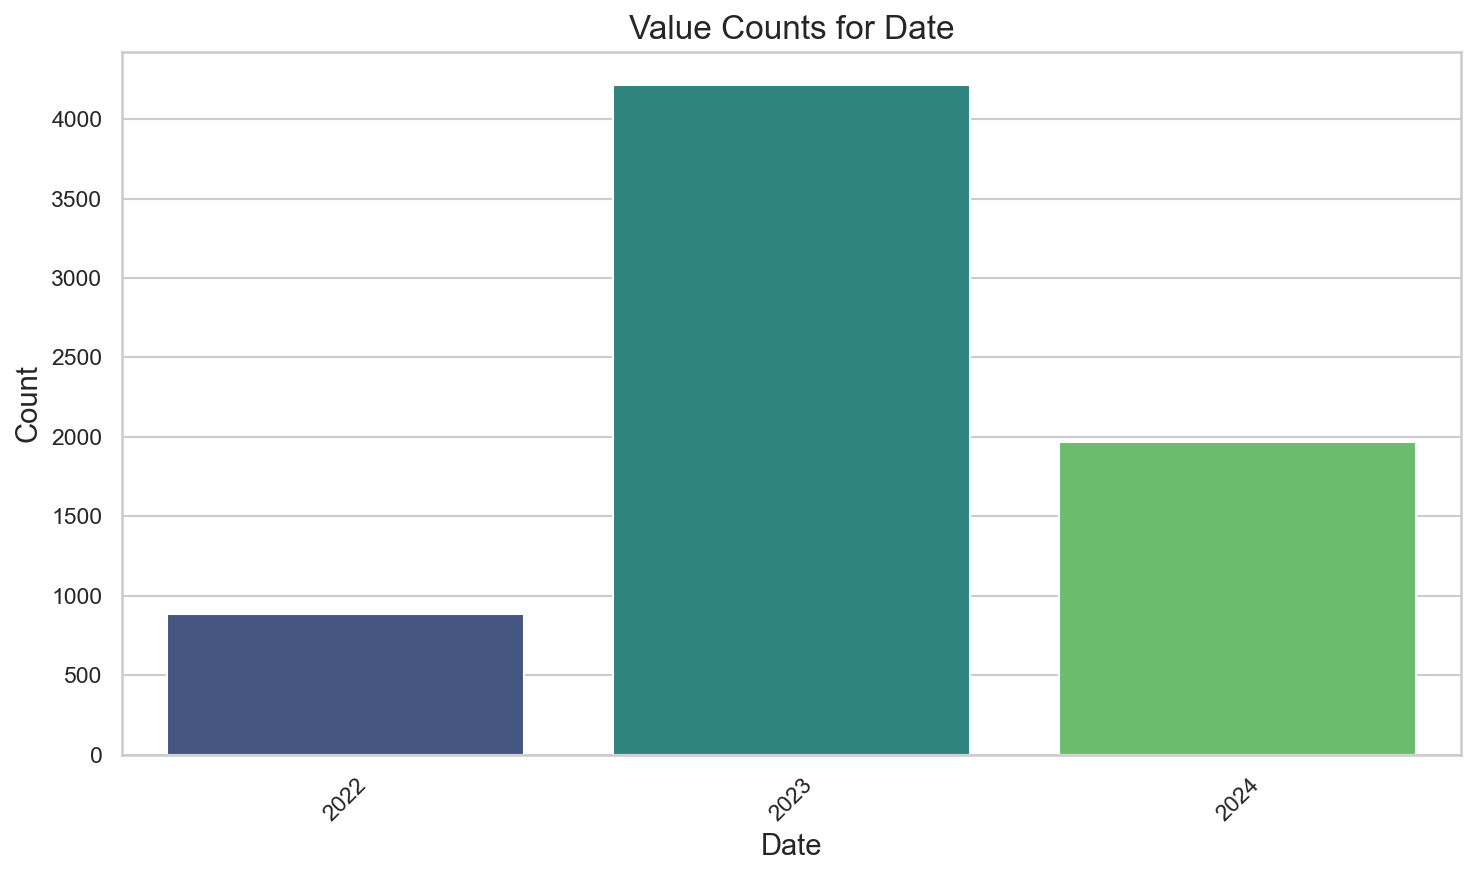

Experience Level: 
Experience Level
SE    4811
MI    1561
EN     512
EX     186
Name: count, dtype: int64



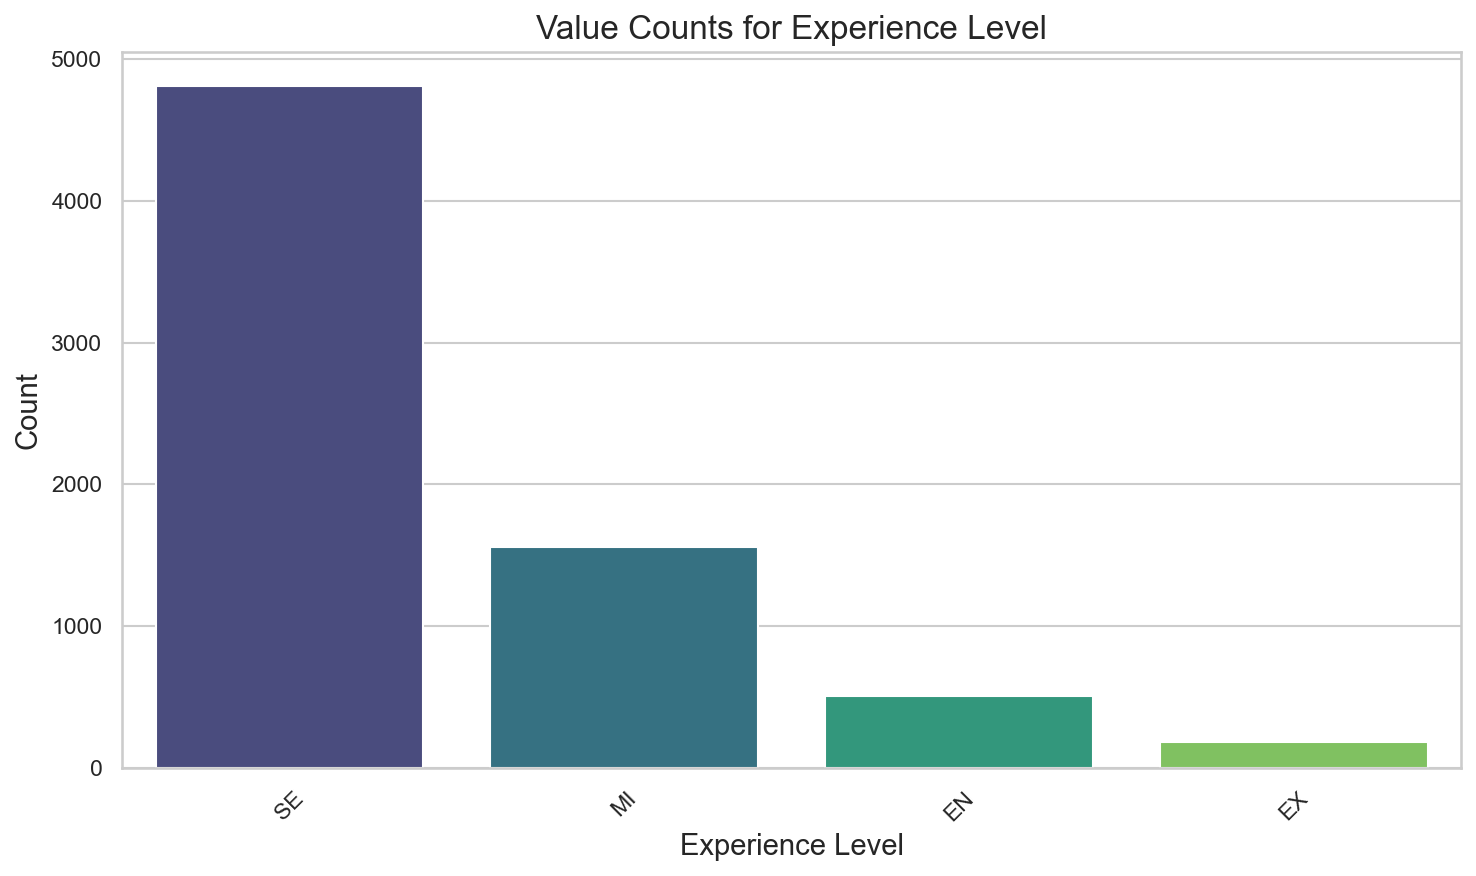

Job Title: 
Job Title
Data Engineer     2701
Data Scientist    2495
Data Analyst      1874
Name: count, dtype: int64



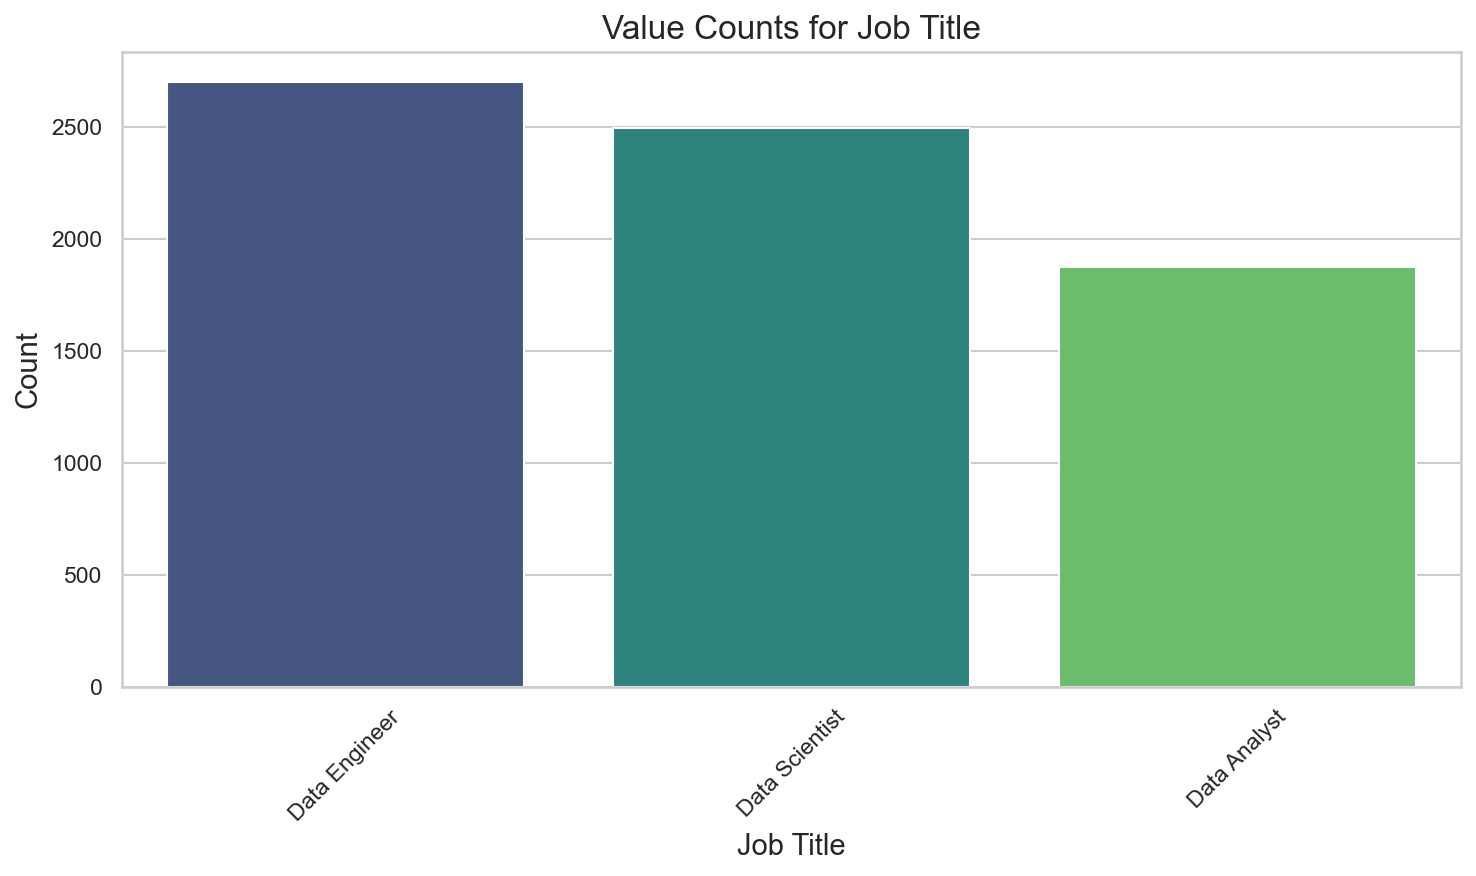

Remote (int): 
Remote (int)
0      4648
100    2422
Name: count, dtype: int64



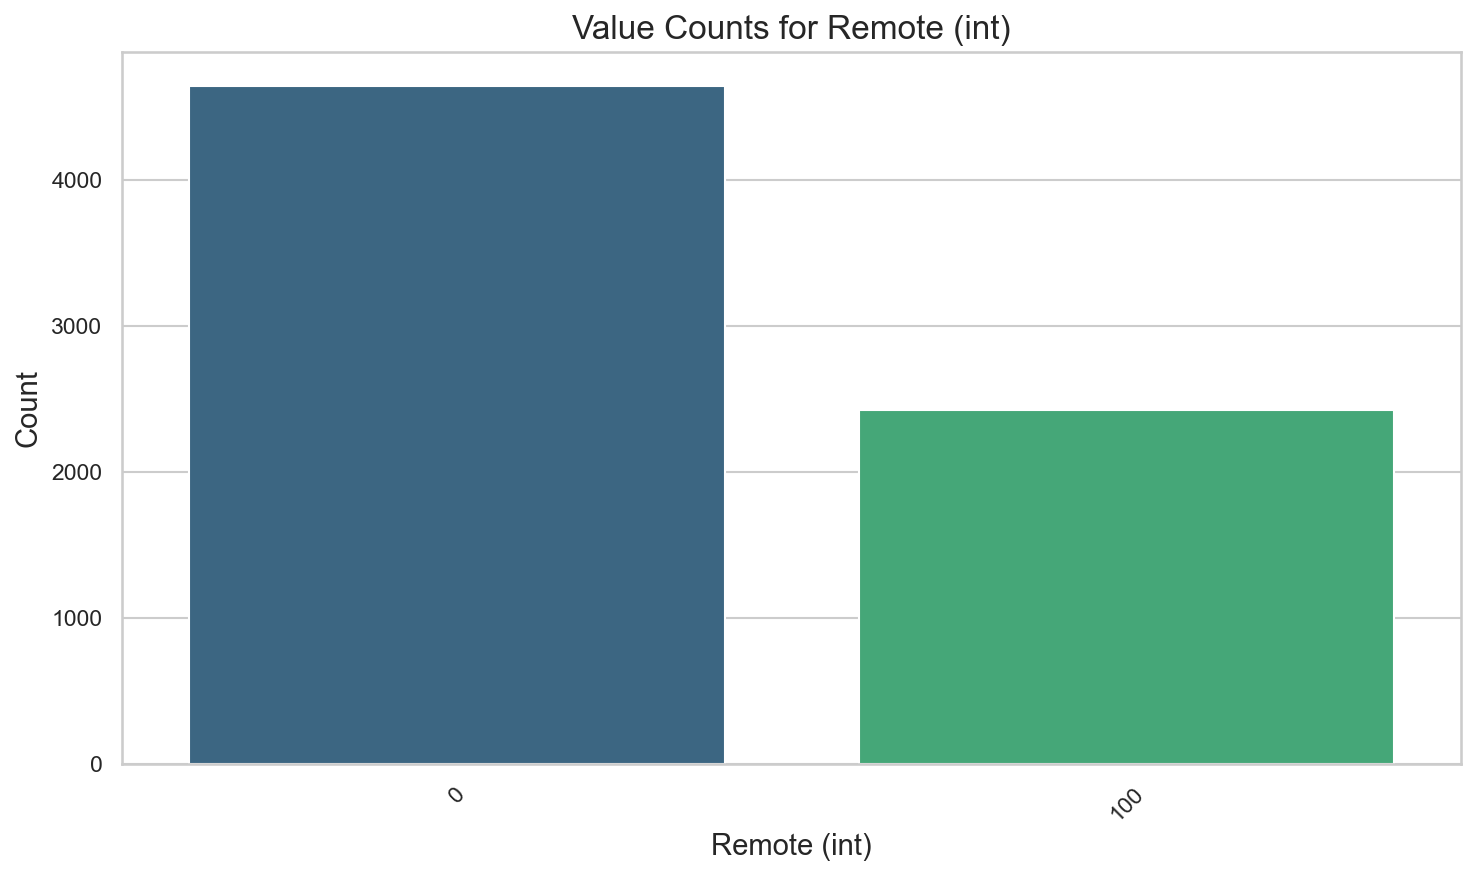

Salary (USD): 
Salary (USD)
130000    184
160000    162
100000    159
150000    157
120000    140
         ... 
123648      1
123625      1
192300      1
123500      1
142127      1
Name: count, Length: 1413, dtype: int64



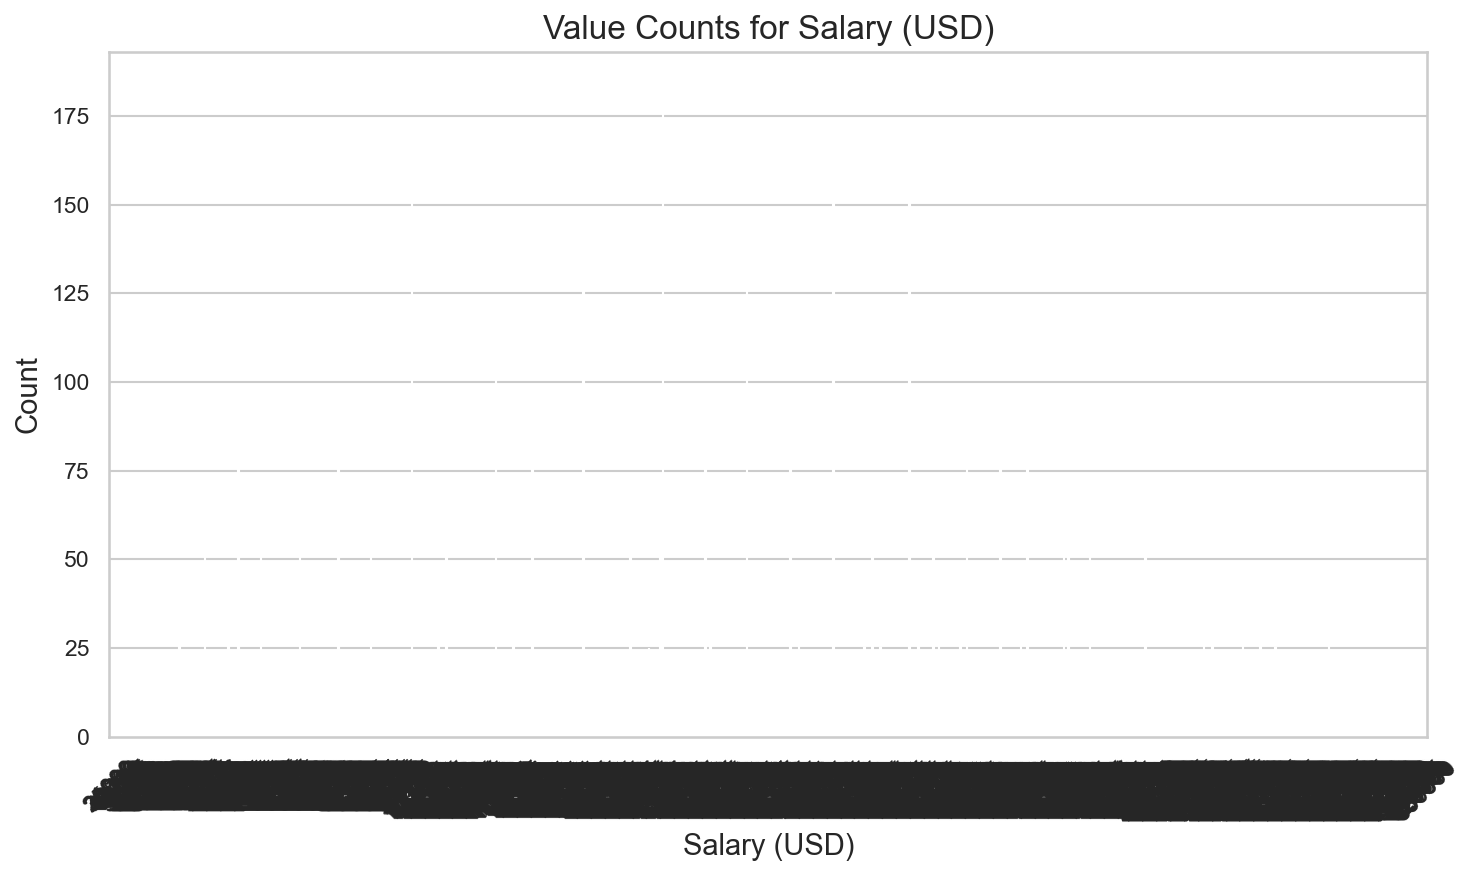

Salary (2024 USD): 
Salary (2024 USD)
130000    184
160000    162
100000    159
150000    157
120000    140
         ... 
123648      1
123625      1
192300      1
123500      1
142127      1
Name: count, Length: 1413, dtype: int64



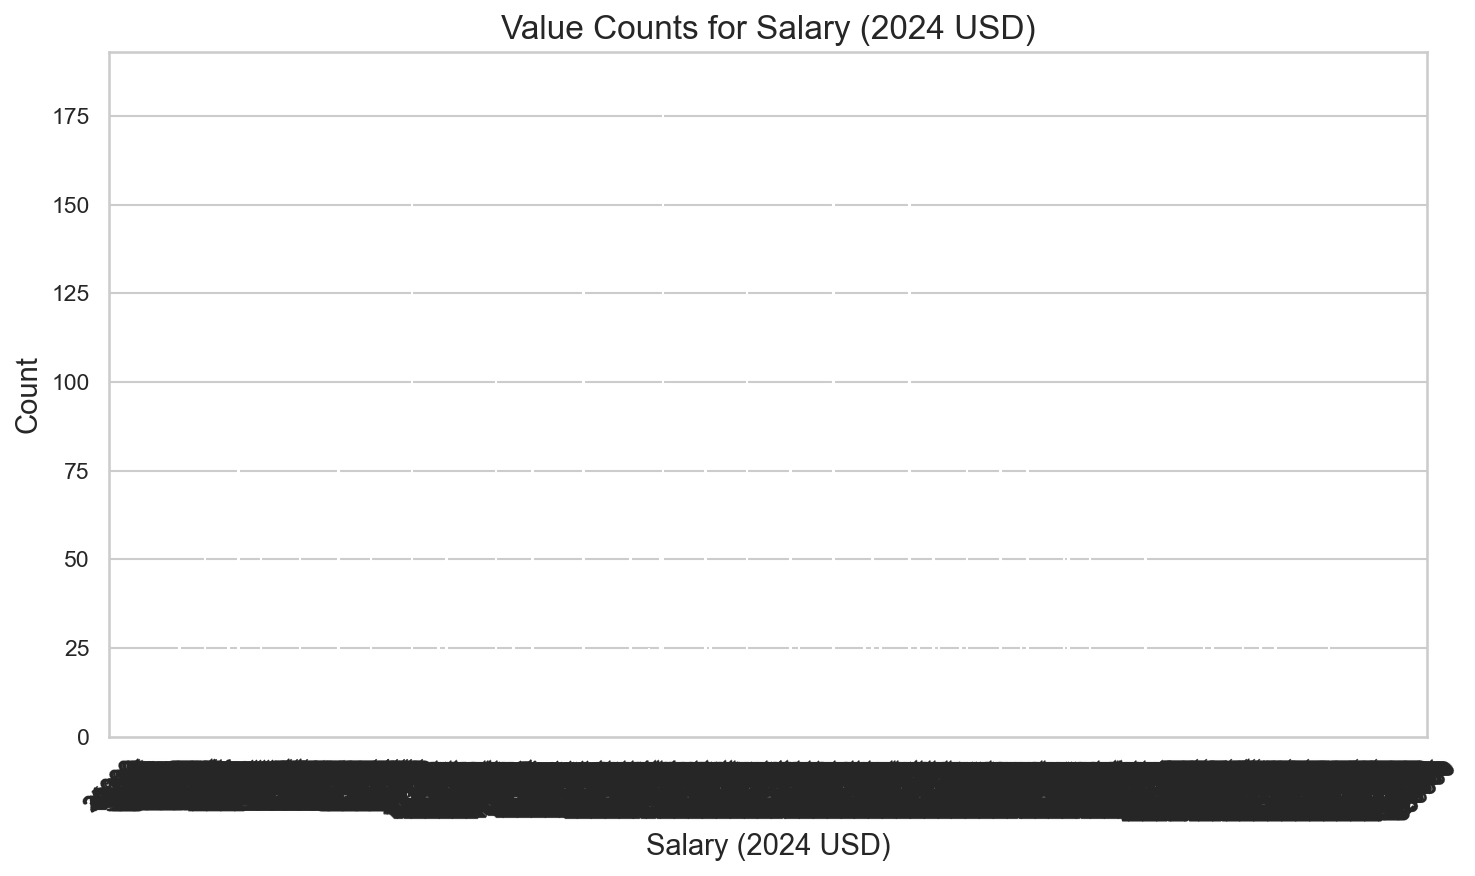

Remote: 
Remote
in-office    4648
remote       2422
Name: count, dtype: int64



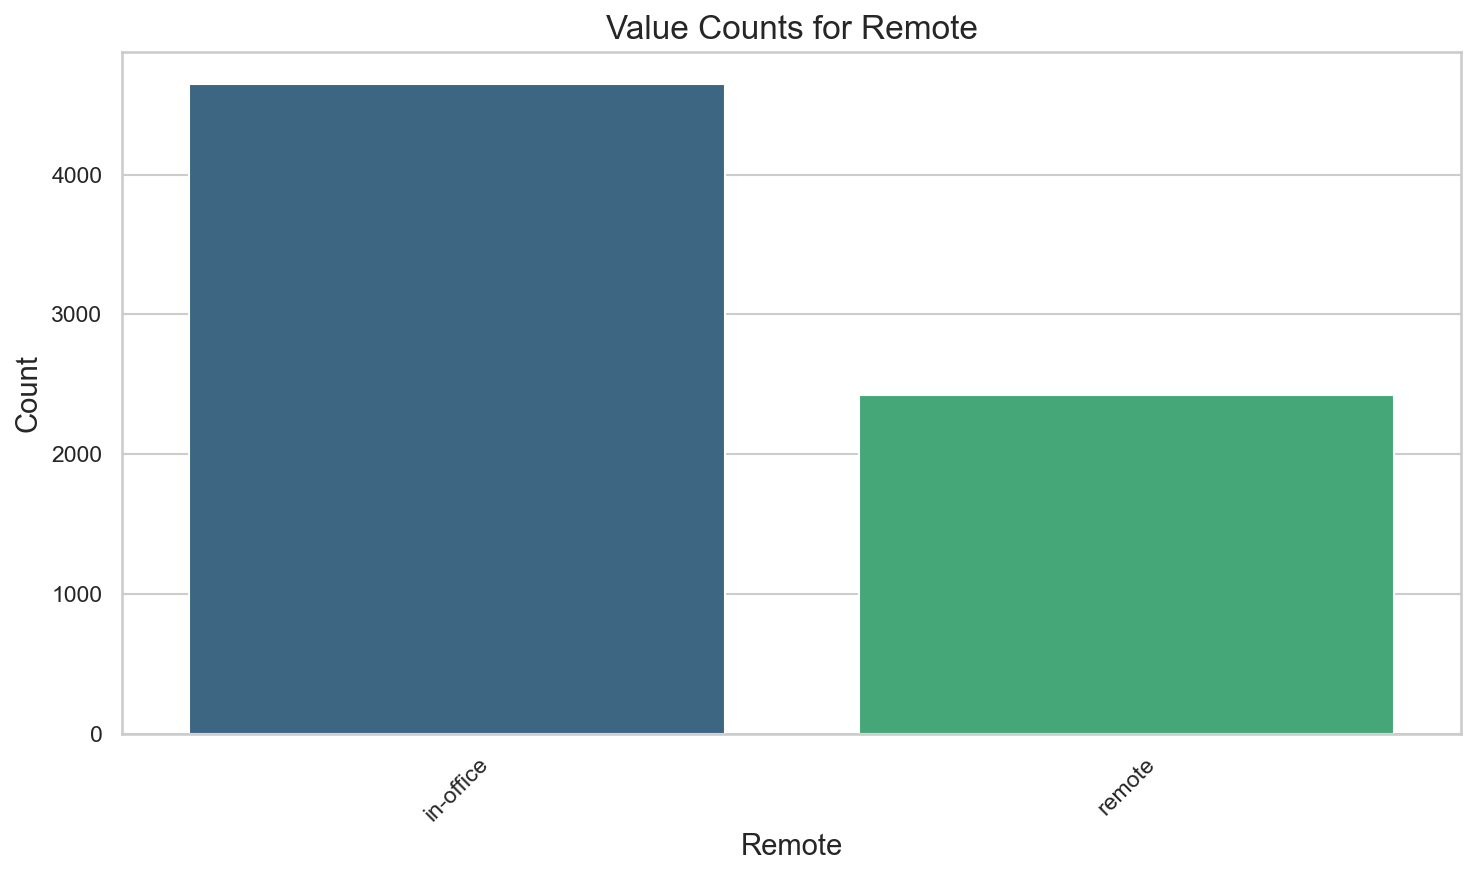

In [11]:
# 3.1 – Record & visualise values + occurences

# Store data as series in dictionary
data_vals = {}

# Set the style for seaborn
sns.set(style="whitegrid")

# Store values & occurences for each column
for col in data.columns:
    data_vals[col] = data[col].value_counts()
    
    # Print the value occurences for the current column
    print(f'{col}: \n{data_vals[col]}\n')
    
    # Bar Plot for value occurences
    plt.figure(figsize = (10, 6), dpi = 150)
    sns.barplot(x=  data_vals[col].index, y = data_vals[col].values, palette = 'viridis')
    
    # Set titles and labels
    plt.title(f'Value Counts for {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to make room for the x-axis labels
    
    # Save plots
    plt.savefig(f'{col}_value_counts.png')  # PNG file
    
    plt.show()
    plt.close()

# This will take a little while. Quite compute-intensive.

In [12]:
# 3.2 – Descriptive stats

# Df of salary stats
salary_stats = (
    data.groupby(['Remote', 'Job Title', 'Experience Level'])['Salary (2024 USD)']
    .agg(
        Median_Salary='median',
        Salary_Range=lambda x: x.max() - x.min(),
        Min_Salary='min',
        Max_Salary='max',
        Salary_Std='std'
    )
)

# Reset index
salary_stats = salary_stats.reset_index()

# Rename columns
col_rename2 = {
    'Median_Salary': 'Median Salary',
    'Salary_Range': 'Salary Range',
    'Min_Salary': 'Min Salary',
    'Max_Salary': 'Max Salary',
    'Salary_Std': 'Salary Standard Deviation'
}

salary_stats.rename(columns = col_rename2, inplace=True)

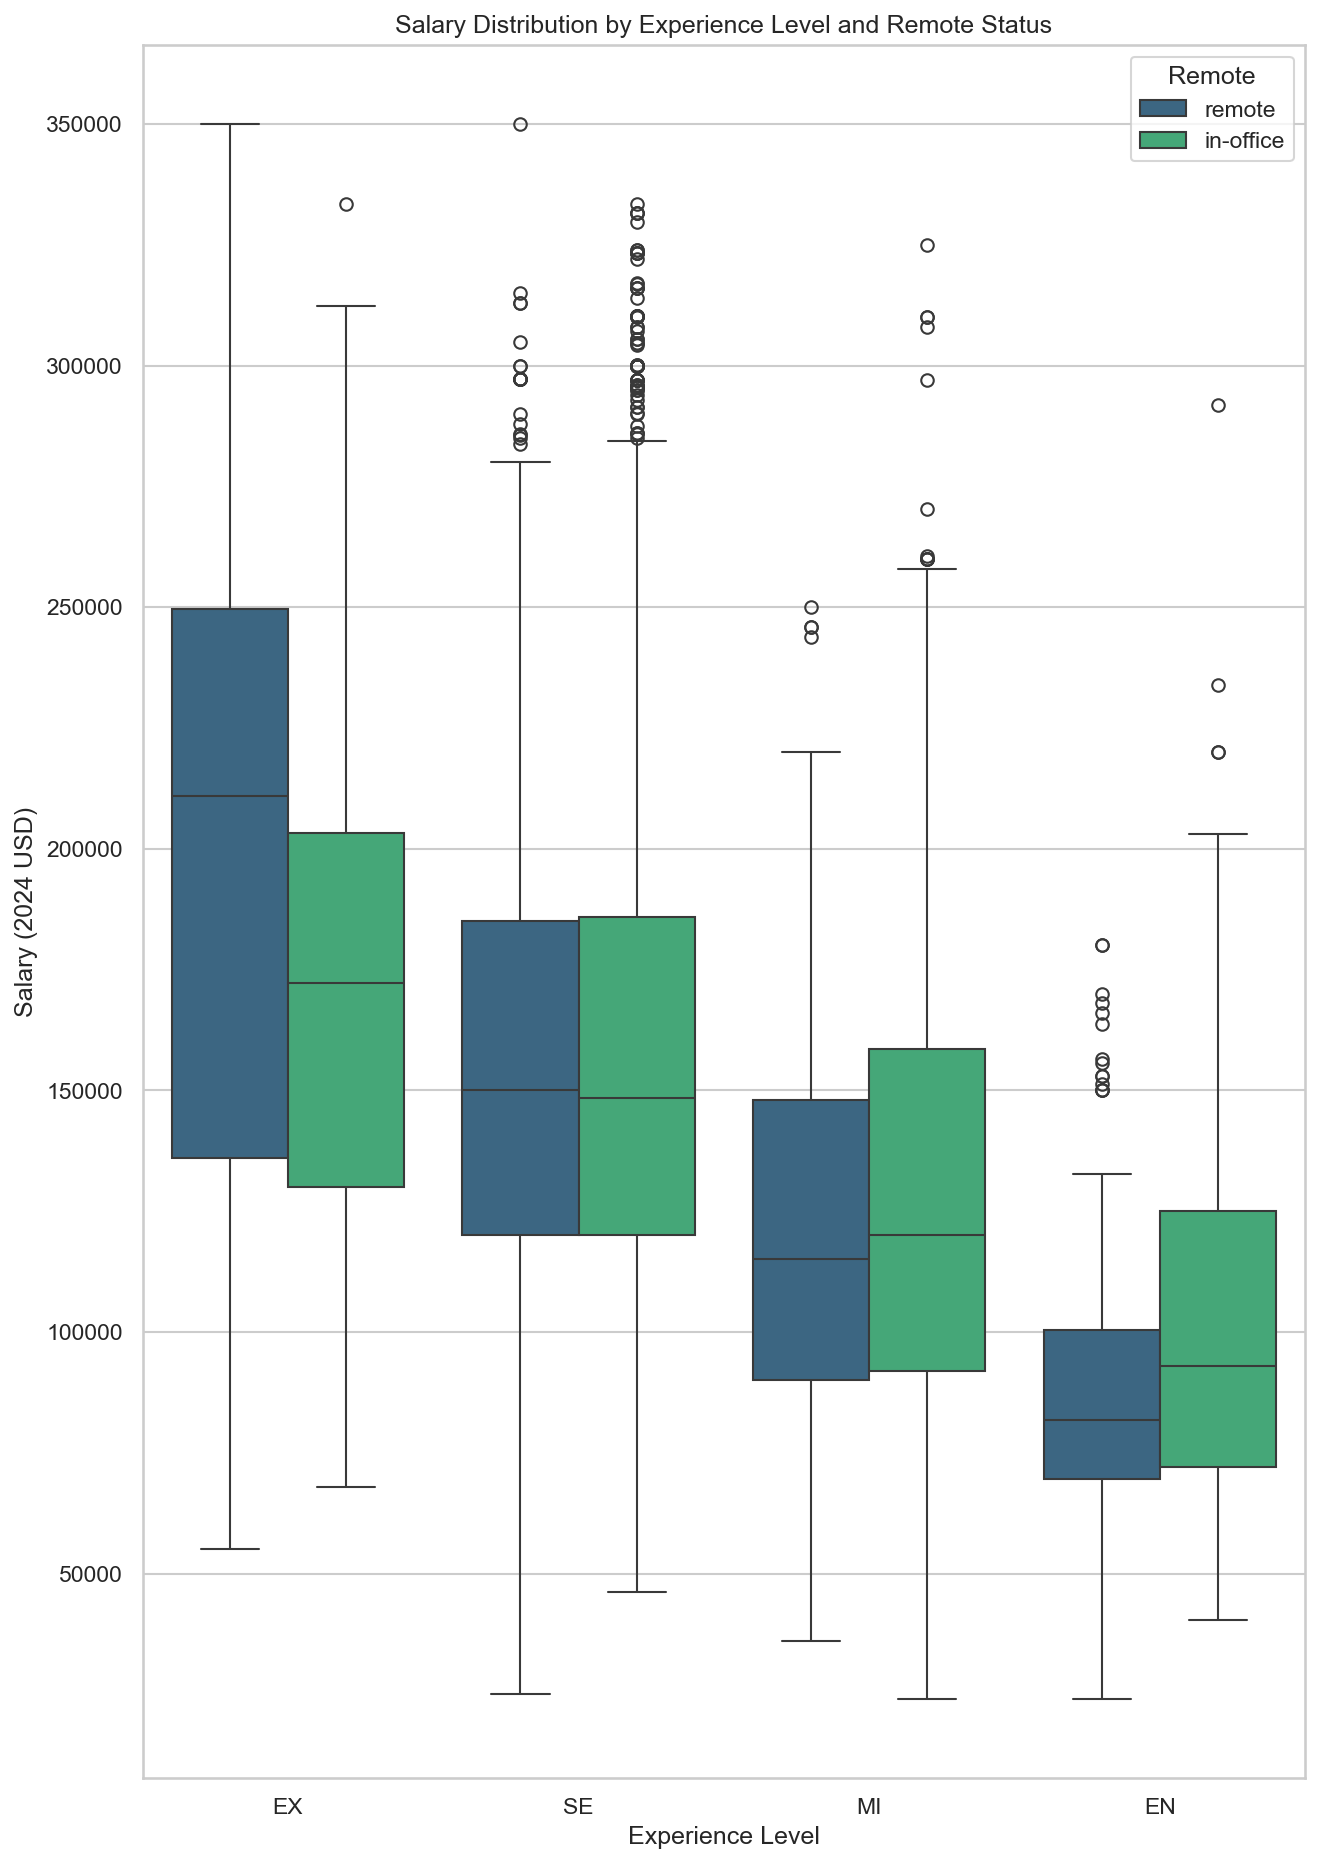

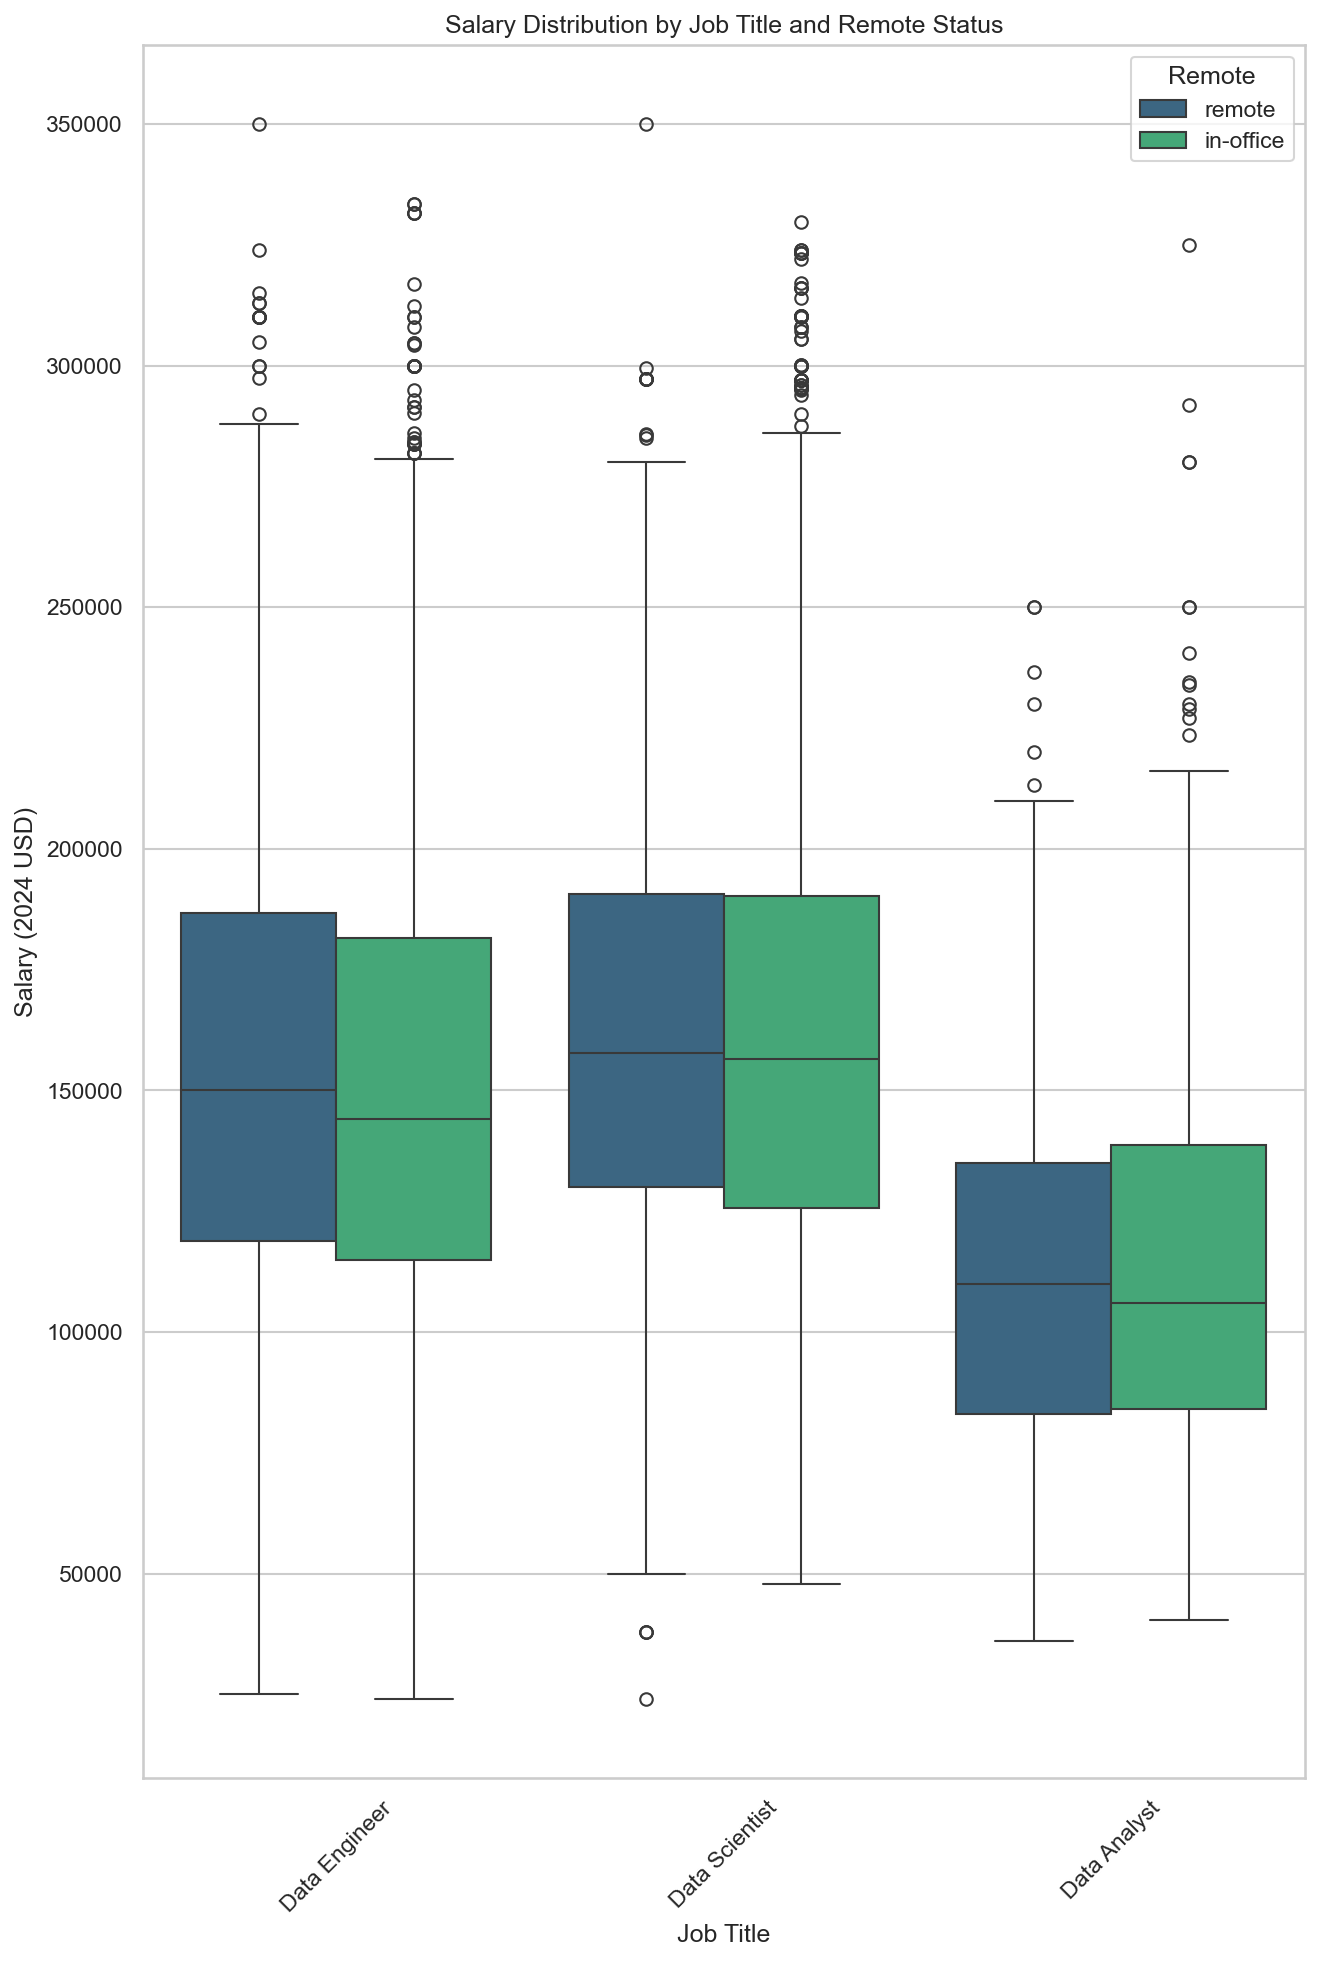

In [13]:
# 3.3 – Descriptive Stat Visualisation

# 3.3.1 – Box plots for salary distribution

# By experience
plt.figure(figsize = (10, 15), dpi = 150)
sns.boxplot(
    data = data,
    x = 'Experience Level',
    y = 'Salary (2024 USD)',
    hue = 'Remote',  # Differentiate between remote and in-office
    palette = 'viridis' # Use viridis palette (talk about this & find refs!!!)
)
plt.title('Salary Distribution by Experience Level and Remote Status')
plt.ylabel('Salary (2024 USD)')
plt.xlabel('Experience Level')
plt.legend(title='Remote')

# Save Figure
plt.savefig('Box Plot (Expereince).png')

plt.show()
plt.close()

# By Title
plt.figure(figsize = (10, 15), dpi = 150)
sns.boxplot(
    data = data,
    x = 'Job Title',
    y = 'Salary (2024 USD)',
    hue = 'Remote',
    palette = 'viridis'
)
plt.title('Salary Distribution by Job Title and Remote Status')
plt.ylabel('Salary (2024 USD)')
plt.xlabel('Job Title')
plt.xticks(rotation=45)
plt.legend(title='Remote')

# Save Figure
plt.savefig('Box Plot (Job Title).png')

plt.show()
plt.close()

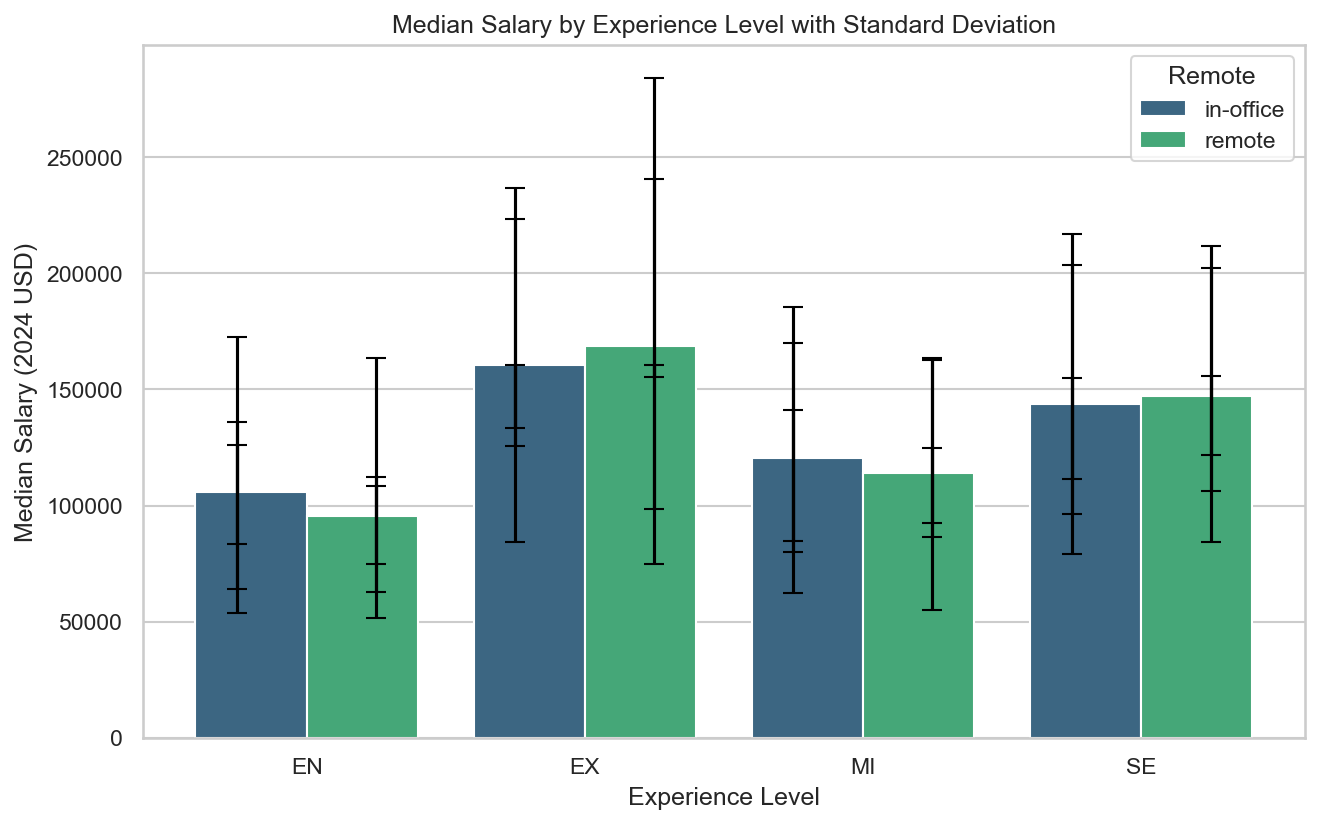

In [14]:
# 3.3.2 – Bar Plot (with error bars)

# Mean and standard deviation for the plot
salary_summary = data.groupby(['Remote', 'Job Title', 'Experience Level']).agg(
    Median_Salary = ('Salary (2024 USD)', 'median'), # Need to keep "_" in names here, spaces no worky
    Salary_Std = ('Salary (2024 USD)', 'std')
).reset_index()

# Plot it
plt.figure(figsize = (10, 6), dpi = 150)
sns.barplot(
    data = salary_summary,
    x = 'Experience Level',
    y = 'Median_Salary',
    hue = 'Remote',
    ci = None,  # Disable internal confidence intervals (comparison clarity over extra precision)
    palette = 'viridis'
)
# Add error bars for standard deviation
for i, row in salary_summary.iterrows():
    plt.errorbar(
        x = i % 4 + (0.25 if row['Remote'] == 'remote' else -0.25),
        y = row['Median_Salary'],
        yerr = row['Salary_Std'],
        fmt = 'none',
        c = 'black',
        capsize = 5
    )
plt.title('Median Salary by Experience Level with Standard Deviation')
plt.ylabel('Median Salary (2024 USD)')
plt.xlabel('Experience Level')
plt.legend(title = 'Remote')

# Save Figure
plt.savefig('Bar Plot (Error Bars).png')

plt.show()
plt.close()

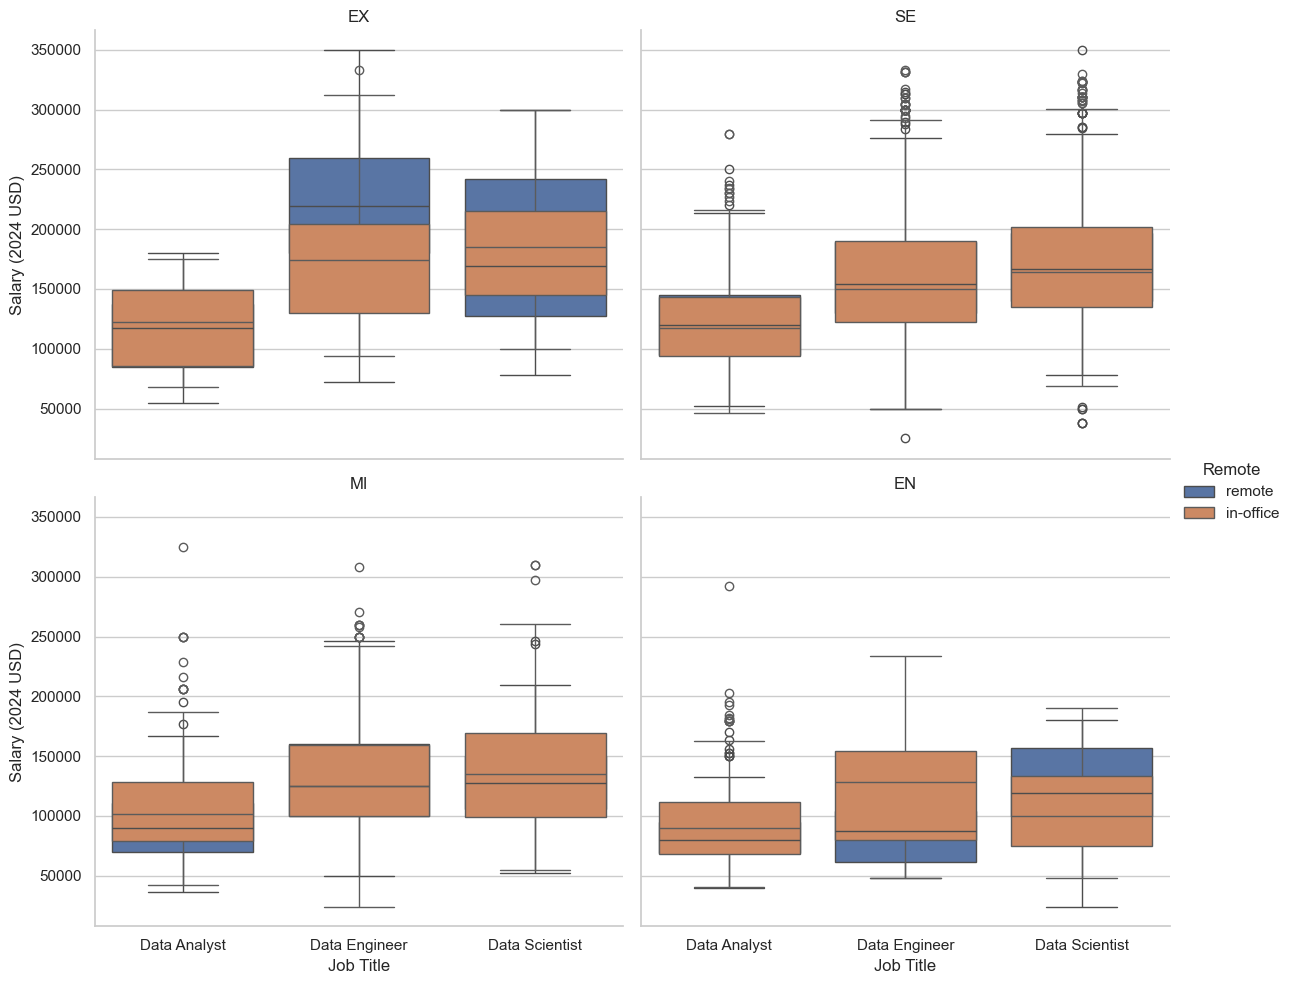

In [15]:
# 3.3.3 – Facet Grid

# Salary Range comparison (Experience & Title)
g = sns.FacetGrid(data, col = 'Experience Level', hue = 'Remote', col_wrap = 2, height = 5, aspect = 1.2)
g.map(sns.boxplot, 'Job Title', 'Salary (2024 USD)', order = ['Data Analyst', 'Data Engineer', 'Data Scientist'])
g.add_legend()
g.set_titles('{col_name}')

# Save Figure
g.savefig('Facet Grid (Experience & Title).png', dpi = 150)

plt.show()
plt.close()

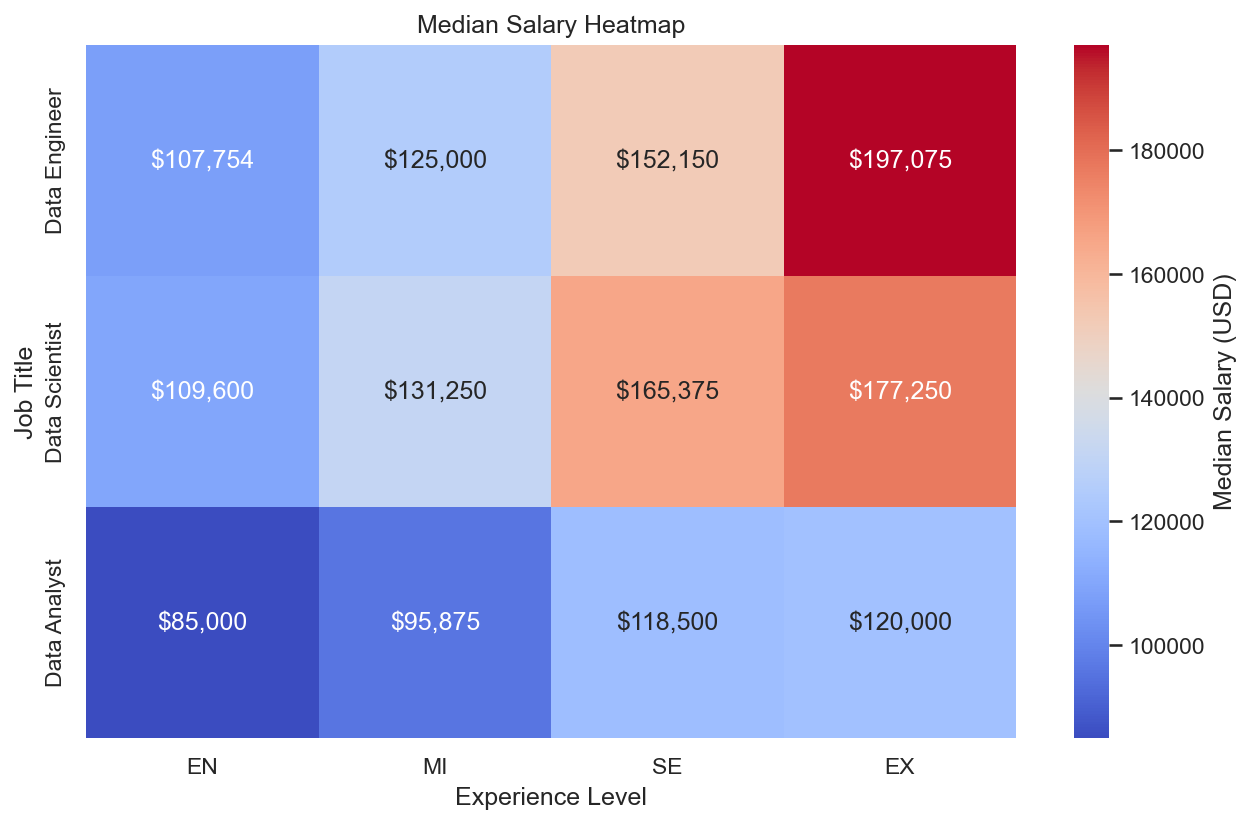

In [16]:
# 3.3.4 – Heat Map (salary stats)

# Create pivot table
pt = salary_stats.pivot_table(values = 'Median Salary', index = 'Job Title', columns = 'Experience Level')

# Specified order for axes
x_order = ['EN', 'MI', 'SE', 'EX']
y_order = ['Data Engineer', 'Data Scientist', 'Data Analyst']

# Reindex the pivot table
pt = pt.reindex(index = y_order, columns = x_order)

# Function for currency format (readability)
def currFormat(x):
    return f'${int(x):,}' if pd.notna(x) else ''  # Check for NaN values

# Set up heat map
plt.figure(figsize = (10, 6), dpi = 150)
sns.heatmap(pt, annot = pt.applymap(currFormat), cmap='coolwarm', fmt = '', cbar_kws = {"label": "Median Salary (USD)"})

plt.title('Median Salary Heatmap')
plt.xlabel('Experience Level')
plt.ylabel('Job Title')

# Save Figure
plt.savefig('Heat Map (Salary Stats).png', dpi = 150)

plt.show()
plt.close()

**4 –  Set-up for Analysis**

In [18]:
# 4.1 – set up for analysis

# 4.1.1 – Data df
# Drop redundant column (adjust code above to be cleaner & clearer)
data.drop(columns = ['Salary (USD)', 'Remote (int)'], inplace = True)

# Check data types
print(data.dtypes)
print(data)

print(" ")
#**********************

# 4.1.2 – aalary_stats

print(salary_stats.dtypes)
print(salary_stats) #(df is good)

Date                  int64
Experience Level     object
Job Title            object
Salary (2024 USD)     int64
Remote               object
dtype: object
      Date Experience Level       Job Title  Salary (2024 USD)     Remote
0     2023               EX   Data Engineer             350000     remote
1     2022               SE  Data Scientist             350000     remote
2     2023               SE   Data Engineer             333500  in-office
3     2023               EX   Data Engineer             333500  in-office
4     2024               SE   Data Engineer             331640  in-office
...    ...              ...             ...                ...        ...
7069  2024               MI   Data Engineer              44721  in-office
7070  2022               SE   Data Engineer              25000     remote
7071  2023               EN  Data Scientist              24000     remote
7072  2022               MI   Data Engineer              24000  in-office
7073  2022               MI   Da

In [19]:
# 4.2 – Convert string columns to integer values

# 4.2.1 – data df

cat_cols = ['Experience Level', 'Job Title', 'Remote']

# New df to hold the converted values
data_int = data.copy()

# Loop to map cols –– CAN NOW REMOVE MANUAL MAPPING AT START OF CODE
for col in cat_cols:
    u_vals = data_int[col].unique() # get unique values
    mapping = {value: idx for idx, value in enumerate(u_vals)}
    
    # Map the values in the DataFrame
    data_int[col] = data_int[col].map(mapping)

print(data_int.dtypes)
print(data_int)

print(" ")
#**************************

# 4.2.2 – salary_stats

# New df to hold the converted values
ss_int = salary_stats.copy()

# Manual mapping to ensure correct order of expertise is observed
ss_int['Experience Level'] = ss_int['Experience Level'].map({'EX': 3, 'SE': 2, 'MI': 1, 'EN': 0})
#ss_int['Job Title'] = ss_int['Job Title'].map({'Data Scientist': 1, 'Data Analyst': 0, 'Data Engineer': 2})
#ss_int['Remote'] = ss_int['Remote'].map({'in-office': 0, 'remote': 1})

for col in cat_cols:
    if col not in ['Experience Level']:  # Skip these columns
        u_vals2 = ss_int[col].unique()  # get unique values
        mapping = {value: idx for idx, value in enumerate(u_vals2)}
        
        # Map the values in the DataFrame
        ss_int[col] = ss_int[col].map(mapping)

print(ss_int.dtypes)
print(ss_int)


Date                 int64
Experience Level     int64
Job Title            int64
Salary (2024 USD)    int64
Remote               int64
dtype: object
      Date  Experience Level  Job Title  Salary (2024 USD)  Remote
0     2023                 0          0             350000       0
1     2022                 1          1             350000       0
2     2023                 1          0             333500       1
3     2023                 0          0             333500       1
4     2024                 1          0             331640       1
...    ...               ...        ...                ...     ...
7069  2024                 2          0              44721       1
7070  2022                 1          0              25000       0
7071  2023                 3          1              24000       0
7072  2022                 2          0              24000       1
7073  2022                 2          0              24000       1

[7070 rows x 5 columns]
 
Remote              

In [20]:
# Check df values suitability

print(data_int.isnull().sum())
print(" ")
print(ss_int.isnull().sum())

Date                 0
Experience Level     0
Job Title            0
Salary (2024 USD)    0
Remote               0
dtype: int64
 
Remote                       0
Job Title                    0
Experience Level             0
Median Salary                0
Salary Range                 0
Min Salary                   0
Max Salary                   0
Salary Standard Deviation    0
dtype: int64


In [21]:
# 4.3 – Save dataframes as csv files

# data
data.to_csv('data.csv', index=False)

# salary_stats
salary_stats.to_csv('salary_stats.csv', index=False)

# data_int
data_int.to_csv('data_int.csv', index=False)

# ss_int
ss_int.to_csv('ss_int.csv', index=False)


**5 – Linear Regression**

In [23]:
# 5.1 – Linear Regression for Salary Prediction

# 5.1.1 – Run the Model

# Define Variables
X = data_int.drop(columns = ['Salary (2024 USD)', 'Date']) # Independent variables
Y = data_int['Salary (2024 USD)'] # Dependent variable

# Add constant
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Salary (2024 USD)   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     491.4
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          5.02e-290
Time:                        16:43:18   Log-Likelihood:                -86297.
No. Observations:                7070   AIC:                         1.726e+05
Df Residuals:                    7066   BIC:                         1.726e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.915e+05   1559.215  

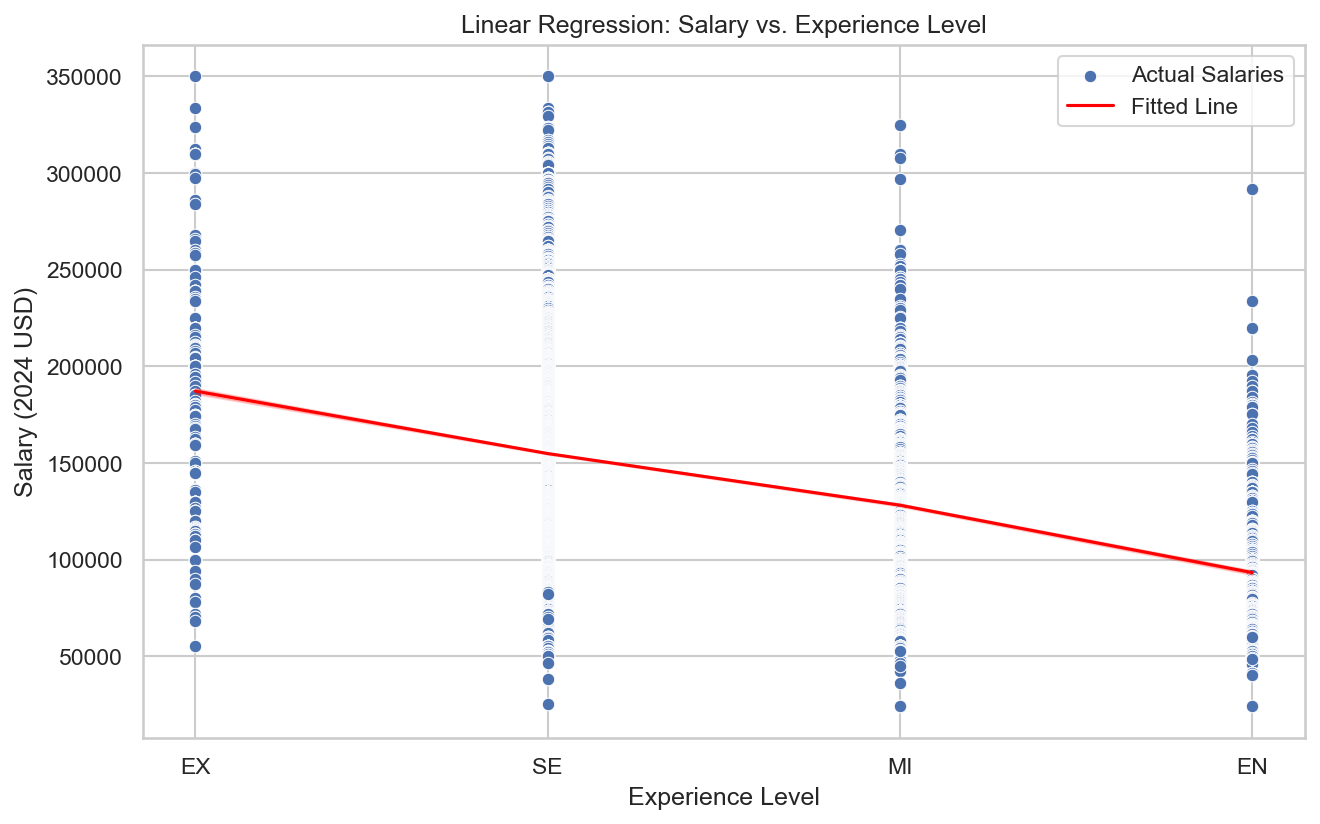

In [24]:
# 5.1.2 – Make Predictions

data_int['Predicted Salary'] = model.predict(X)

#*************************************

# 5.1.3 – Visualise the Regression

plt.figure(figsize=(10, 6), dpi = 150)
sns.scatterplot(data=data_int, x = 'Experience Level', y = 'Salary (2024 USD)', label = 'Actual Salaries')
sns.lineplot(data = data_int, x = 'Experience Level', y = 'Predicted Salary', color = 'red', label = 'Fitted Line')

# Customise x-axis labels
plt.xticks(ticks = [3, 2, 1, 0], labels = ['EN', 'MI', 'SE', 'EX'])

plt.title('Linear Regression: Salary vs. Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary (2024 USD)')

# Save Figure
plt.savefig('Linear Regression (Salary vs Experience).png')

plt.show()
plt.close()

In [25]:
# 5.2 – Regression on median salary

# Prepare features and target variable
X = ss_int[['Remote', 'Job Title', 'Experience Level', 'Min Salary', 'Max Salary', 'Salary Standard Deviation']]  # Independent variables
y = ss_int['Median Salary']  # Dependent variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Output the evaluation metrics
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Display the coefficients of the model
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

# Add prediction coumn to df
ss_int['Predicted Salary'] = model.predict(X)

Mean Squared Error: 32295261.79
Mean Absolute Error: 5219.20
R-squared: 0.96
                            Coefficient
Remote                      7264.242734
Job Title                  10486.175609
Experience Level            8826.975337
Min Salary                     0.299524
Max Salary                     0.166986
Salary Standard Deviation      0.948409


In [26]:
# 5.2.1 – Regression on median salary (w/o 'Experience Level')
# Found anomaly in salaries for EX Scientist & Engineer

ss_int2 = ss_int.copy()

ss_int2 = ss_int2.loc[ss_int2['Experience Level'] != 3]

# Prepare features and target variable
X = ss_int2[['Remote', 'Job Title', 'Experience Level', 'Min Salary', 'Max Salary', 'Salary Standard Deviation']]  # Independent variables
y = ss_int2['Median Salary']  # Dependent variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Output the evaluation metrics
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Display the coefficients of the model
coefficients = pd.DataFrame(model.coef_, X.columns, columns = ['Coefficient'])
print(coefficients)

# Add prediction coumn to df
ss_int2['Predicted Salary'] = model.predict(X)

ss_int2

Mean Squared Error: 20420519.92
Mean Absolute Error: 3701.32
R-squared: 0.98
                            Coefficient
Remote                      9328.895953
Job Title                   9609.552320
Experience Level           11142.816414
Min Salary                     0.163449
Max Salary                     0.054677
Salary Standard Deviation      1.701992


,Remote,Job Title,Experience Level,Median Salary,Salary Range,Min Salary,Max Salary,Salary Standard Deviation,Predicted Salary
0,0,0,0,90000.0,251600,40300,291900,36053.054343,89846.230581
2,0,0,1,101750.0,282600,42400,325000,39270.689752,108618.486088
3,0,0,2,117000.0,233800,46200,280000,38005.091412,115767.909085
4,0,1,0,127958.0,186160,47840,234000,44720.932551,112275.052942
6,0,1,1,125000.0,284000,24000,308000,45058.020201,124141.055124
7,0,1,2,150000.0,283500,50000,333500,53525.698506,155339.731079
8,0,2,0,100000.0,142160,47840,190000,36082.461822,104776.213281
10,0,2,1,135000.0,255448,54552,310000,50430.613185,147997.769568
11,0,2,2,164000.0,260583,69117,329700,52689.683304,166443.277613
12,1,0,0,80000.0,130000,40000,170000,28277.436928,79226.935694


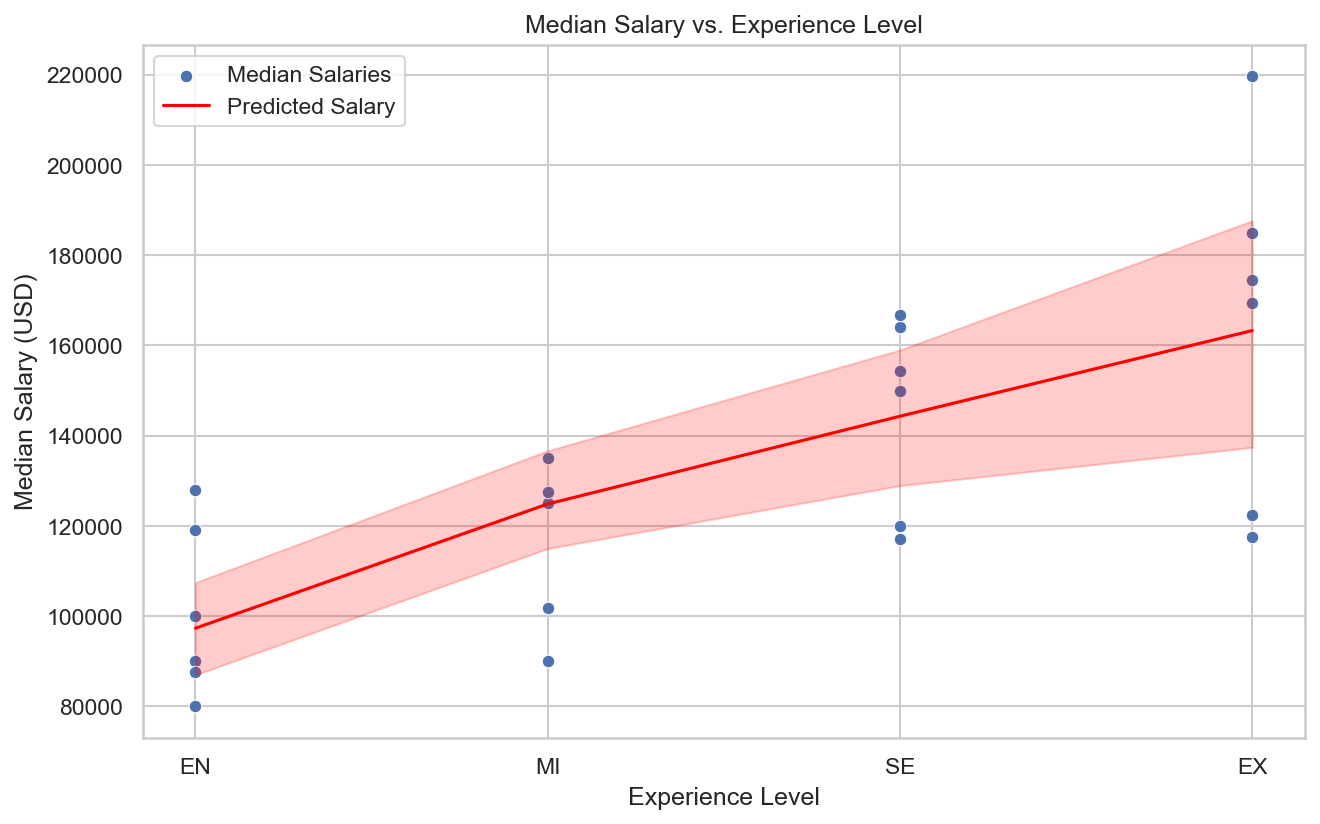

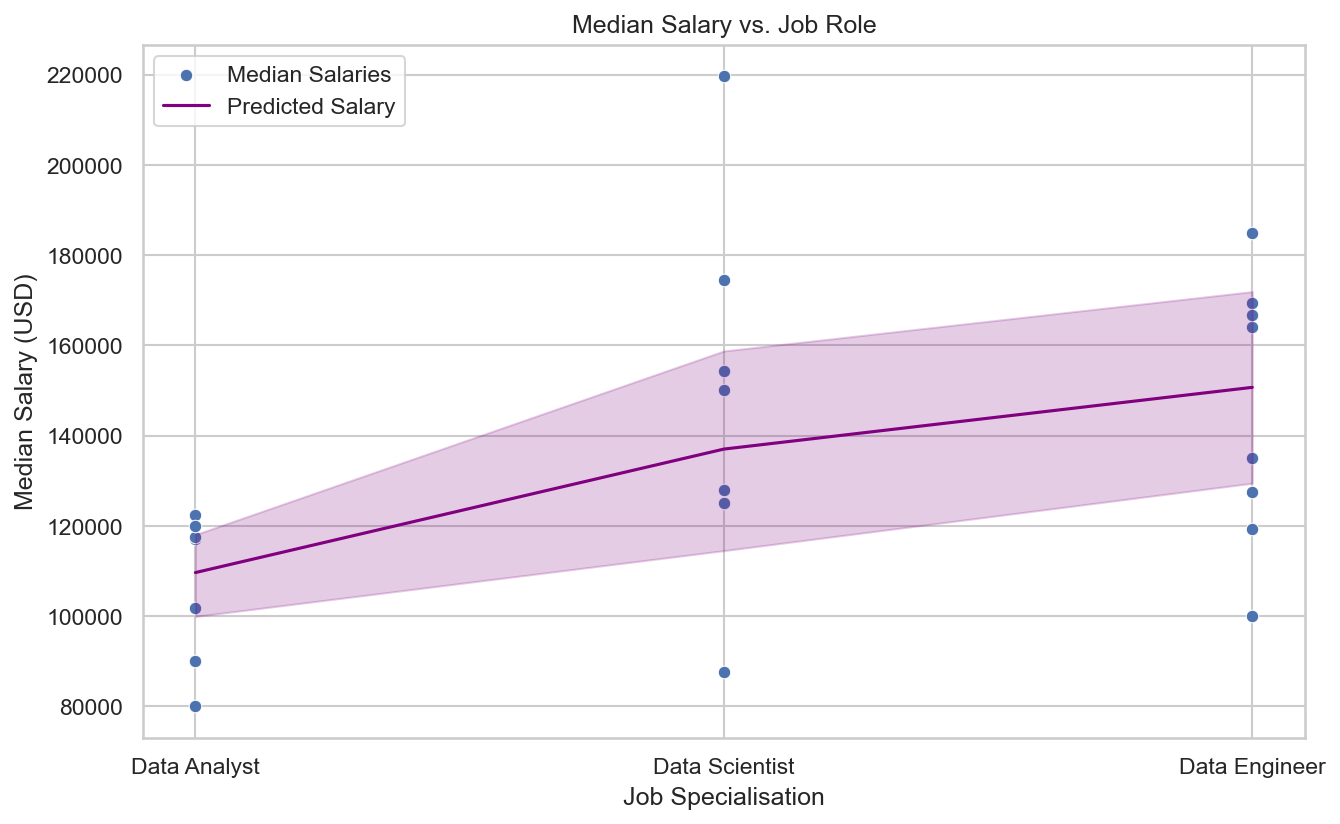

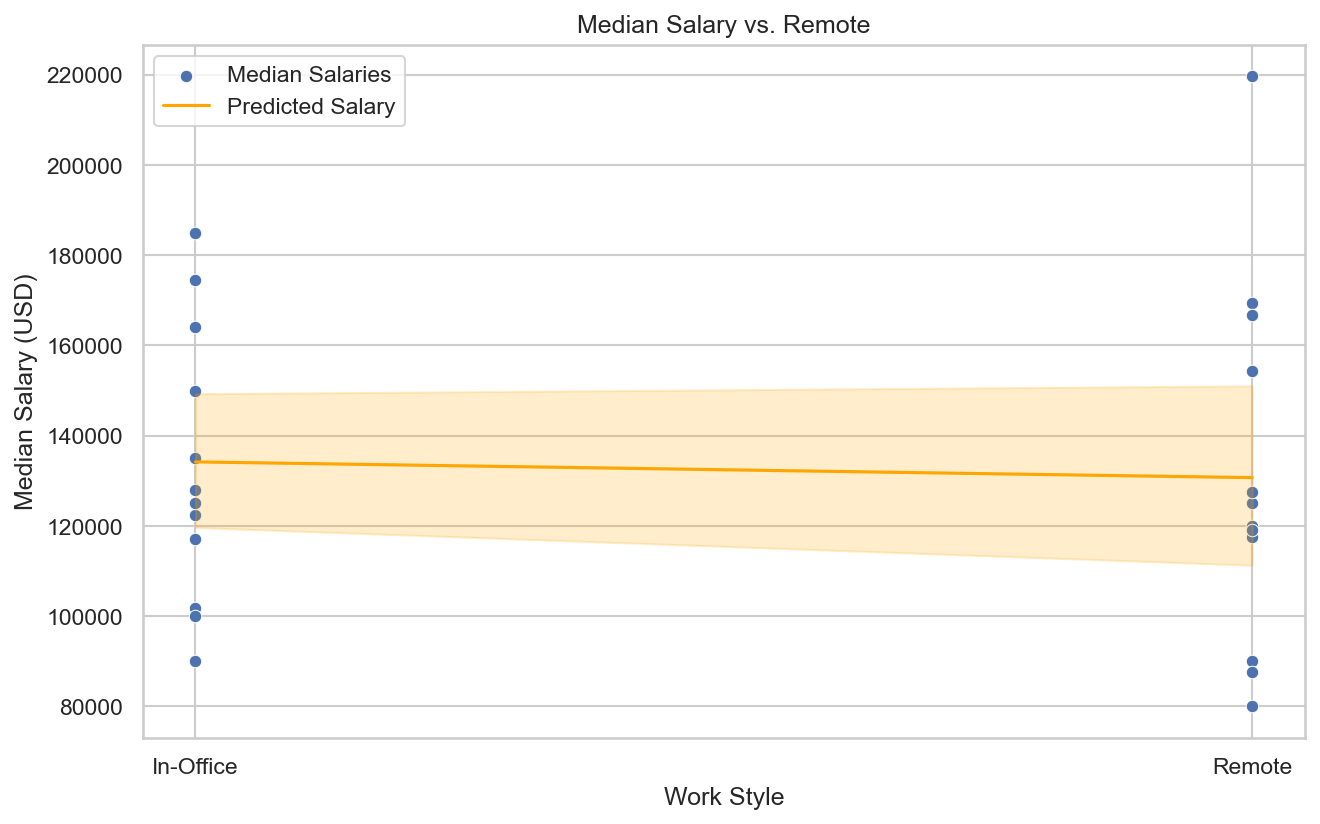

In [27]:
# 5.3 – Visualise the Regression on ss_int

# 5.3.1 – Median Salary vs. Experience Level

plt.figure(figsize = (10, 6), dpi = 150)
sns.scatterplot(data = ss_int, x = 'Experience Level', y = 'Median Salary', label = 'Median Salaries')
sns.lineplot(data = ss_int, x = 'Experience Level', y = 'Predicted Salary', color = 'red', label = 'Predicted Salary')

# Customise x-axis labels
plt.xticks(ticks = [3, 2, 1, 0], labels = ['EX', 'SE', 'MI', 'EN'])

plt.title('Median Salary vs. Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Median Salary (USD)')
plt.legend(loc = 'upper left')

# Save Figure
plt.savefig('Linear Regression (Median Salary vs. Experience).png')

plt.show()
plt.close()

#***************************

# 5.3.2 – Median Salary vs. Job Title

plt.figure(figsize = (10, 6), dpi = 150)
sns.scatterplot(data = ss_int, x = 'Job Title', y = 'Median Salary', label = 'Median Salaries')
sns.lineplot(data = ss_int, x = 'Job Title', y = 'Predicted Salary', color = 'purple', label = 'Predicted Salary')

# Customise x-axis labels
plt.xticks(ticks = [2, 1, 0], labels = ['Data Engineer', 'Data Scientist', 'Data Analyst'])

plt.title('Median Salary vs. Job Role')
plt.xlabel('Job Specialisation')
plt.ylabel('Median Salary (USD)')
plt.legend(loc = 'upper left')

# Save Figure
plt.savefig('Linear Regression (Median Salary vs. Role).png')

plt.show()
plt.close()

#***************************

# 5.3.3 – Median Salary vs. Remote

plt.figure(figsize = (10, 6), dpi = 150)
sns.scatterplot(data = ss_int, x = 'Remote', y = 'Median Salary', label = 'Median Salaries')
sns.lineplot(data = ss_int, x = 'Remote', y = 'Predicted Salary', color = 'orange', label = 'Predicted Salary')

# Customise x-axis labels
plt.xticks(ticks = [1, 0], labels = ['Remote', 'In-Office'])

plt.title('Median Salary vs. Remote')
plt.xlabel('Work Style')
plt.ylabel('Median Salary (USD)')
plt.legend(loc = 'upper left')

# Save Figure
plt.savefig('Linear Regression (Median Salary vs. Remote).png')

plt.show()
plt.close()

In [28]:
# 5.4 – Testing for overfitting
# Use data df data and run it through the model. Check if results are the same as above.

# New df to hold the converted values
data_int2 = data.copy()

# Manual mapping to ensure correct order of expertise is observed
data_int2['Experience Level'] = data_int2['Experience Level'].map({'EX': 3, 'SE': 2, 'MI': 1, 'EN': 0})
data_int2['Job Title'] = data_int2['Job Title'].map({'Data Scientist': 1, 'Data Analyst': 0, 'Data Engineer': 2})
data_int2['Remote'] = data_int2['Remote'].map({'in-office': 0, 'remote': 1})

print(data_int2.dtypes)
print(data_int2)

Date                 int64
Experience Level     int64
Job Title            int64
Salary (2024 USD)    int64
Remote               int64
dtype: object
      Date  Experience Level  Job Title  Salary (2024 USD)  Remote
0     2023                 3          2             350000       1
1     2022                 2          1             350000       1
2     2023                 2          2             333500       0
3     2023                 3          2             333500       0
4     2024                 2          2             331640       0
...    ...               ...        ...                ...     ...
7069  2024                 1          2              44721       0
7070  2022                 2          2              25000       1
7071  2023                 0          1              24000       1
7072  2022                 1          2              24000       0
7073  2022                 1          2              24000       0

[7070 rows x 5 columns]


In [29]:
# 5.4.1 – Regressoion on data round 2

# Prepare features and target variable
X = data_int2[['Date', 'Remote', 'Job Title', 'Experience Level']]  # Independent variables
y = data_int2['Salary (2024 USD)']  # Dependent variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Output the evaluation metrics
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Display the coefficients of the model
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Mean Squared Error: 2368172787.58
Mean Absolute Error: 37948.83
R-squared: 0.17
                   Coefficient
Date               3436.933928
Remote             -958.401402
Job Title         14054.406384
Experience Level  26466.205455


Results match previous run, which is an argument against the model overfitting on median salary data.

However, it cannot fully rule it out. It's just one test, and both models are pretty poor at explaining things with an r-squared of 0.17.

Could use multiple similar datasets to test it further.

**6 – Hierarchical Clustering**

In [32]:
# 6.1 – Prep data for this type of analysis & visualisation

# NOTE: This would probably be more suited to being earlier in the code

# 6.1.1 – Create dictionary of identifier tags

identifiers = {
    ('remote', 'EN', 'Data Analyst'): 'R-EN Analyst',
    ('remote', 'MI', 'Data Analyst'): 'R-MI Analyst',
    ('remote', 'SE', 'Data Analyst'): 'R-SE Analyst',
    ('remote', 'EX', 'Data Analyst'): 'R-EX Analyst',
    ('in-office', 'EN', 'Data Analyst'): 'IO-EN Analyst',
    ('in-office', 'MI', 'Data Analyst'): 'IO-MI Analyst',
    ('in-office', 'SE', 'Data Analyst'): 'IO-SE Analyst',
    ('in-office', 'EX', 'Data Analyst'): 'IO-EX Analyst',
    ('remote', 'EN', 'Data Scientist'): 'R-EN Scientist',
    ('remote', 'MI', 'Data Scientist'): 'R-MI Scientist',
    ('remote', 'SE', 'Data Scientist'): 'R-SE Scientist',
    ('remote', 'EX', 'Data Scientist'): 'R-EX Scientist',
    ('in-office', 'EN', 'Data Scientist'): 'IO-EN Scientist',
    ('in-office', 'MI', 'Data Scientist'): 'IO-MI Scientist',
    ('in-office', 'SE', 'Data Scientist'): 'IO-SE Scientist',
    ('in-office', 'EX', 'Data Scientist'): 'IO-EX Scientist',
    ('remote', 'EN', 'Data Engineer'): 'R-EN Engineer',
    ('remote', 'MI', 'Data Engineer'): 'R-MI Engineer',
    ('remote', 'SE', 'Data Engineer'): 'R-SE Engineer',
    ('remote', 'EX', 'Data Engineer'): 'R-EX Engineer',
    ('in-office', 'EN', 'Data Engineer'): 'IO-EN Engineer',
    ('in-office', 'MI', 'Data Engineer'): 'IO-MI Engineer',
    ('in-office', 'SE', 'Data Engineer'): 'IO-SE Engineer',
    ('in-office', 'EX', 'Data Engineer'): 'IO-EX Engineer',
}

# 6.1.2 – Define function to apply identifier tags

def rowID(row):
    key = (row['Remote'], row['Experience Level'], row['Job Title'])
    return identifiers.get(key, 'OUTLIER') # In case dataset grows, added an outlier tag


In [33]:
# 6.2 – Add identifier tags to dfs

# 6.2.1 – Apply the function to salary_stats

salary_stats['Identifier'] = salary_stats.apply(rowID, axis=1)

print(salary_stats)

#******************************
print(" ")

ss_int['Identifier'] = salary_stats['Identifier']

print(ss_int)

       Remote       Job Title Experience Level  Median Salary  Salary Range  \
0   in-office    Data Analyst               EN        90000.0        251600   
1   in-office    Data Analyst               EX       122500.0        107000   
2   in-office    Data Analyst               MI       101750.0        282600   
3   in-office    Data Analyst               SE       117000.0        233800   
4   in-office   Data Engineer               EN       127958.0        186160   
5   in-office   Data Engineer               EX       174500.0        239500   
6   in-office   Data Engineer               MI       125000.0        284000   
7   in-office   Data Engineer               SE       150000.0        283500   
8   in-office  Data Scientist               EN       100000.0        142160   
9   in-office  Data Scientist               EX       185000.0        200000   
10  in-office  Data Scientist               MI       135000.0        255448   
11  in-office  Data Scientist               SE      

Silhouette Score: 0.202
Calinski-Harabasz Index: 8.103


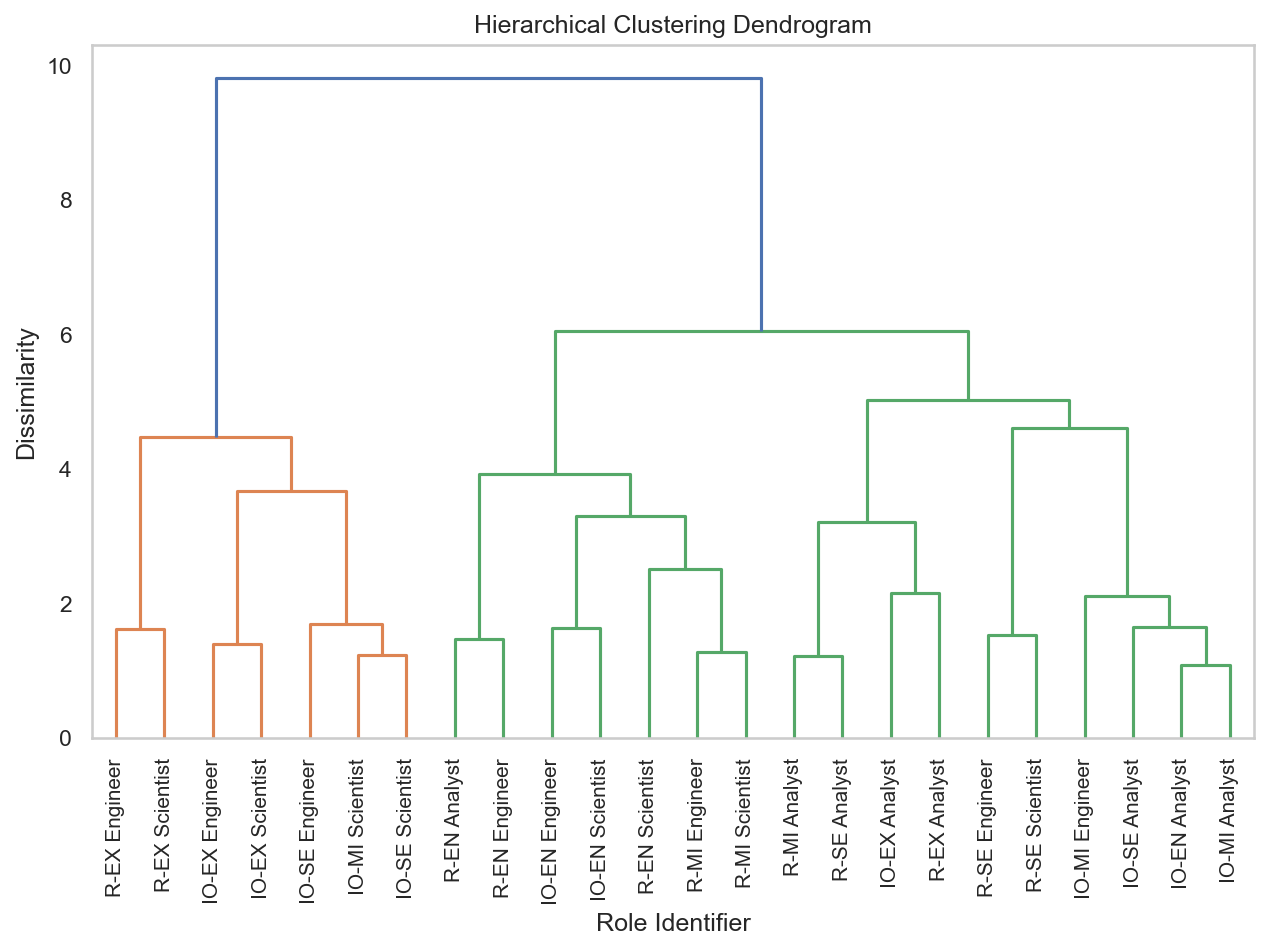

In [34]:
# 6.3 – H-Clusters on Median Data

x_labels = ss_int['Identifier'].tolist()

# Scaler
scaler = StandardScaler()

# Choose features & normalise data
features = ss_int[['Job Title', 'Experience Level', 'Remote', 'Min Salary', 'Max Salary', 'Salary Standard Deviation']]
f_scaled = scaler.fit_transform(features)

# Linkage matrix
l_matrix = linkage(f_scaled, method = 'ward')

# Determine the number of clusters or threshold to cut the dendrogram
num_clusters = 4  # Adjust this number based on your analysis
cluster_labels = fcluster(l_matrix, num_clusters, criterion='maxclust')

# Now you can evaluate the clustering
silhouette_avg = silhouette_score(f_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

ch_score = calinski_harabasz_score(f_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {ch_score:.3f}')

# Plot dendrogram with cluster labels
plt.figure(figsize = (10, 6), dpi = 150)
dendrogram(l_matrix, labels = x_labels, leaf_rotation = 90)  # Use x_labels for labels

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Role Identifier')  # Change xlabel to "Identifier"
plt.ylabel('Dissimilarity')
plt.grid(False)

# Save Figure
plt.savefig('Dendogram (HC – Ward – ss_int).png')

plt.show()
plt.close()

Silhouette Score: 0.307
Calinski-Harabasz Index: 2142.070


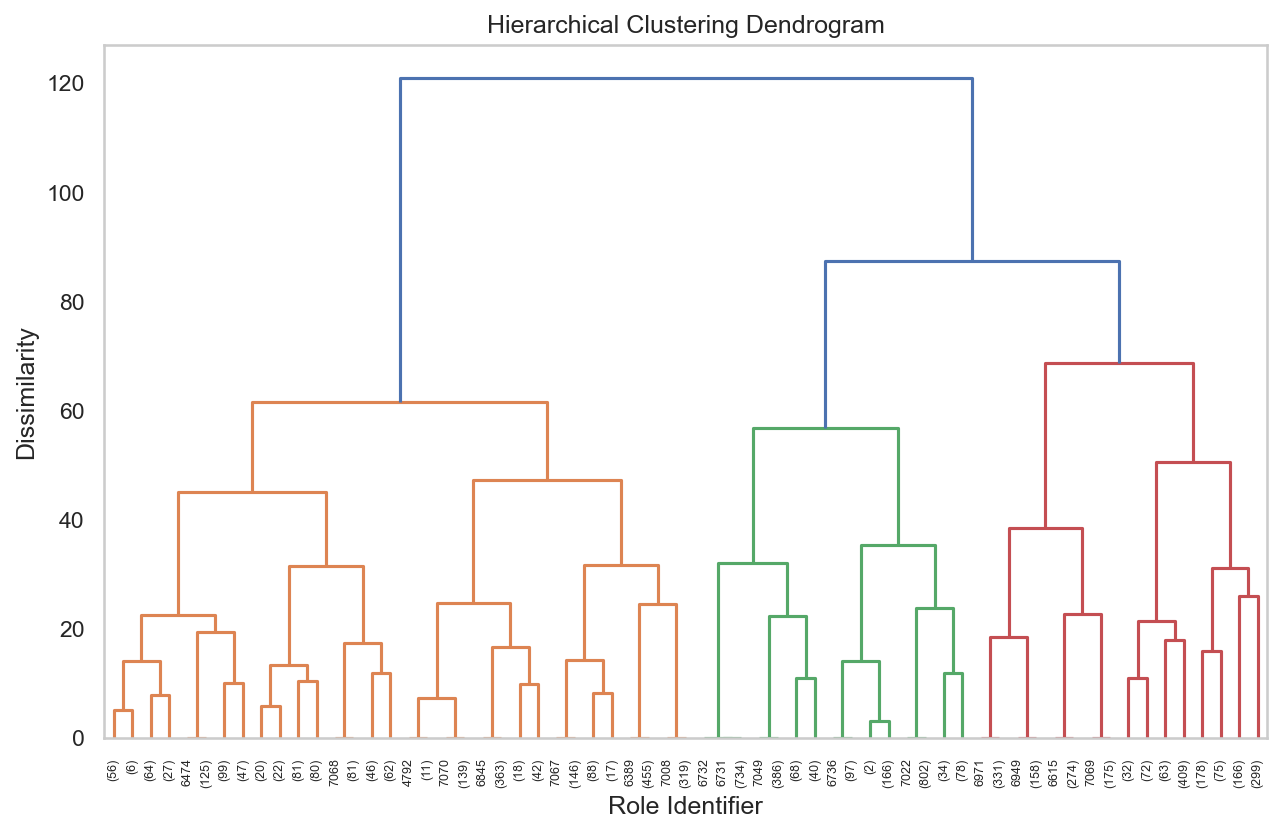

In [35]:
# 6.4 – H-Clustering on Full Data

# Choose features & normalise data
features = data_int[['Date', 'Experience Level', 'Job Title', 'Remote']] # 'Salary (2024 USD)' not included. Try with after.
f_scaled = scaler.fit_transform(features) # Defined in 6.3

# Linkage matrix
l_matrix = linkage(f_scaled, method='ward')

# Determine the number of clusters or threshold to cut the dendrogram
num_clusters = 4  # Adjust this number based on your analysis
cluster_labels = fcluster(l_matrix, num_clusters, criterion='maxclust')

# Now you can evaluate the clustering
silhouette_avg = silhouette_score(f_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

ch_score = calinski_harabasz_score(f_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {ch_score:.3f}')

# Plot dendrogram with cluster labels
plt.figure(figsize=(10, 6), dpi=150)
dendrogram(l_matrix, labels=data_int.index, leaf_rotation=90, truncate_mode='level', p=5)  # change p to determine how many levels are rendered

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Role Identifier')  # Change xlabel to "Identifier"
plt.ylabel('Dissimilarity')
plt.grid(False)

# Save Figure
plt.savefig('Dendogram (HC – Ward – data_int).png')

plt.show()
plt.close()

In [36]:
# 6.5 – Iterating on H-Clustering

# 6.5.1 – Define features & iterate through combinations
all_f = ['Date', 'Experience Level', 'Job Title', 'Remote', 'Salary (2024 USD)']
combo_f = [list(combo) for n in range(2, 5) for combo in itertools.combinations(all_f, n)]

# List to store evaluation results
evals_list = []

# Set the scaler
scaler = StandardScaler()

#*****************************************

# 6.5.2 – Loop through each combo of features

for i, f_set in enumerate(combo_f, start = 1):
    
    # Select and scale the subset of features
    select_f = data_int[f_set]
    f_scaled = scaler.fit_transform(select_f)

    # Compute the linkage matrix
    l_matrix = linkage(f_scaled, method = 'ward')

    # Determine number of clusters
    num_clusters = 4  # Adjustable
    cluster_labels = fcluster(l_matrix, num_clusters, criterion='maxclust')

    # Evaluate the clustering
    silhouette_avg = silhouette_score(f_scaled, cluster_labels)
    ch_score = calinski_harabasz_score(f_scaled, cluster_labels)
    
    # Append the results to the list
    evals_list.append({
        'Features': f_set,
        'Silhouette Score': silhouette_avg,
        'Calinski-Harabasz Index': ch_score
    })

    # Probably best to not print every single one
    '''# Plot the dendrogram
    plt.figure(figsize=(10, 6), dpi=150)
    dendrogram(l_matrix, labels=data_int.index, leaf_rotation=90, truncate_mode='lastp', p=30)
    plt.title(f'HC Dendrogram (Features: {f_set})')
    plt.xlabel('Sample Index')
    plt.ylabel('Dissimilarity')
    plt.grid(False)
    plt.savefig(f'HC Dendrogram (ward – {f_set}).png')
    plt.show()
    plt.close()'''

#***************************************

# 6.5.3 – Convert results to a DataFrame

hc_evals = pd.DataFrame(evals_list)

# Convert the feature sets to strings for clarity
hc_evals['Features'] = hc_evals['Features'].apply(lambda x: ', '.join(x))

print(hc_evals)

                                             Features  Silhouette Score  \
0                              Date, Experience Level          0.741615   
1                                     Date, Job Title          0.610405   
2                                        Date, Remote          0.833075   
3                             Date, Salary (2024 USD)          0.486674   
4                         Experience Level, Job Title          0.663860   
5                            Experience Level, Remote          0.878162   
6                 Experience Level, Salary (2024 USD)          0.504369   
7                                   Job Title, Remote          0.766070   
8                        Job Title, Salary (2024 USD)          0.480861   
9                           Remote, Salary (2024 USD)          0.539115   
10                  Date, Experience Level, Job Title          0.375175   
11                     Date, Experience Level, Remote          0.524264   
12          Date, Experie

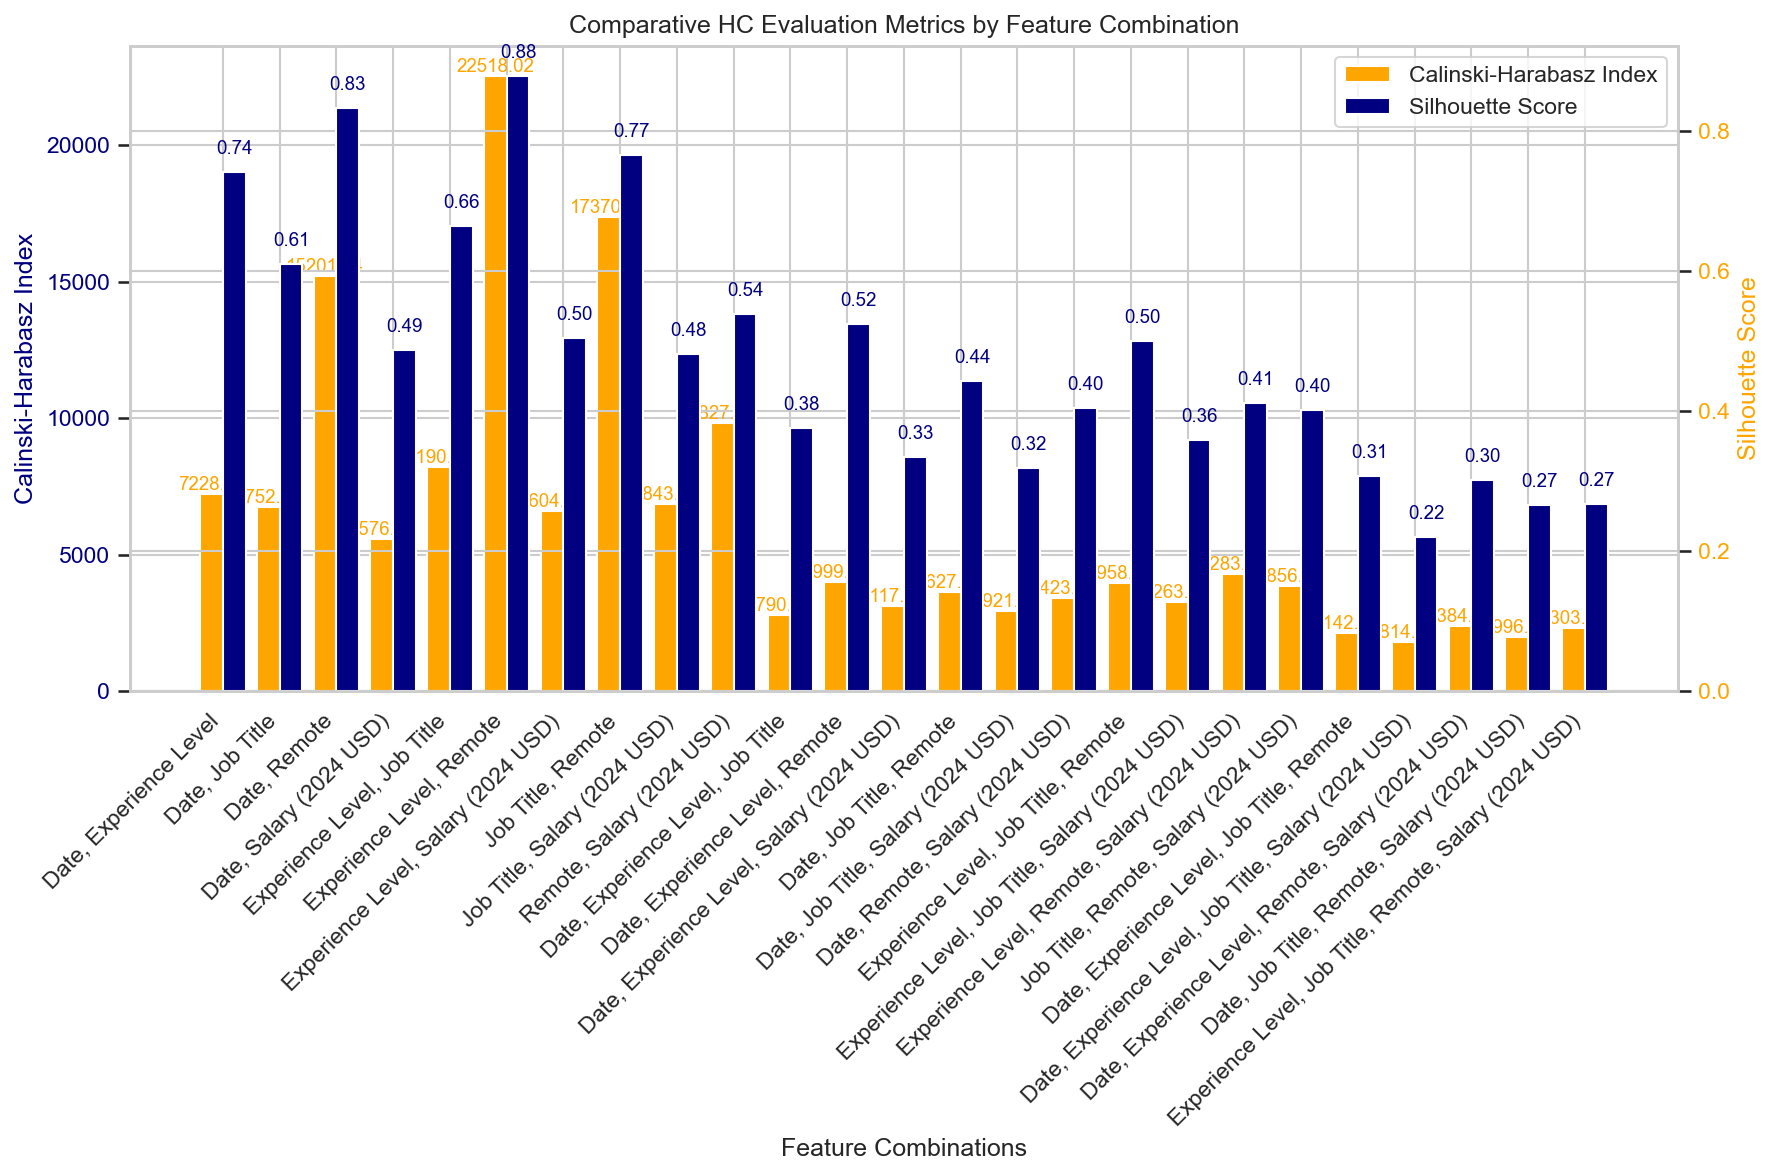

In [37]:
# 6.6 – Plot Different HC evaluations

# Set the positions and width for the bars
x = np.arange(len(hc_evals))  # X locations for the feature combinations
width = 0.4  # Width of the bars

# Create the figure and axes
fig, ax1 = plt.subplots(figsize = (12, 8), dpi = 150)

# Plot the Calinski-Harabasz Index on the primary y-axis (left)
ch_bars = ax1.bar(x - width/2, hc_evals['Calinski-Harabasz Index'], width,\
                  label = 'Calinski-Harabasz Index', color = 'orange')

ax1.set_ylabel('Calinski-Harabasz Index', color = 'navy')
ax1.tick_params(axis = 'y', labelcolor = 'navy')

# Create a secondary y-axis for the Silhouette Score
ax2 = ax1.twinx()
silhouette_bars = ax2.bar(x + width/2, hc_evals['Silhouette Score'], width,\
                          label = 'Silhouette Score', color = 'navy')

ax2.set_ylabel('Silhouette Score', color = 'orange')
ax2.tick_params(axis = 'y', labelcolor = 'orange')

# Add labels, title, and custom x-axis tick labels
ax1.set_xlabel('Feature Combinations')
ax1.set_title('Comparative HC Evaluation Metrics by Feature Combination')
ax1.set_xticks(x)
ax1.set_xticklabels(hc_evals['Features'], rotation = 45, ha = 'right')

# Add the value labels on top of each bar
for bar in ch_bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}',\
             ha = 'center', va = 'bottom', fontsize = 9, color = 'orange')

for bar in silhouette_bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}',\
             ha = 'center', va = 'bottom', fontsize = 9, color = 'navy')

# Display the legend for each y-axis
fig.legend(loc = "upper right", bbox_to_anchor = (1,1), bbox_transform = ax1.transAxes)

# Adjust layout
plt.tight_layout()

plt.savefig('Comparative HC Evaluation.png')

plt.show()
plt.close()